In [36]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import imageio


def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        score = []
        nb_eval = []
        n_eval_tot = 0
        pop_size = []
        for row in csv_data :
            for i in range(2,len(row[:-1])) :
                n_eval_tot+=1
                score.append(float(row[i]))    
                nb_eval.append(n_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, pop_size, score

def load_fitness_of_gen(filename,obj,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        fitnesses = []
        for row in csv_data :
            if(int(row[0]) == 0) :
                for i in range(3,len(row[:-1]),int(row[2])) :
                     fitnesses.append(float(row[i+obj]))
                break
    return fitnesses

def load_robustness_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        pop_size = [int(row[1]) for i,row in enumerate(csv_data) if i == 0]
        fitnesses = [[] for _ in range(pop_size[0])]
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data :
            for i in range(3,len(row[:-1])) :
                fitnesses[i-3].append(float(row[i]))
    return fitnesses

def load_best_fit_mo(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fit1 = []
        best_fit2 = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = [0,0]
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i]) > best_fitness[0]) :
                    best_fitness = [float(row[i]),float(row[i+1])]
                    
            best_fit1.append(best_fitness[0])
            best_fit2.append(best_fitness[1])
            nb_eval.append(nb_eval_tot)
            pop_size.append(float(row[1]))
            
    return nb_eval, best_fit1, best_fit2, pop_size


def histo_nbeval(nbeval,bins) :
    histo = [0 for b in bins]
    for nbe in nbeval :
        for i in range(0,len(bins)) :
            if(nbe < int(bins[i])) :
                histo[i] += 1
                break
    for i in range(0,len(histo)) :
        histo[i] = float(histo[i])/float(len(nbeval))*100
    return histo

def best_fit(fitnesses_vec,from_i) :
    best_fits = []
    for fits in fitnesses_vec :
        best_fits.append(max(fits[from_i:]))
    return best_fits

def load_eval_time(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        durations = []
        eval_nb = []
        for row in csv_data :
            durations.append(float(row[1])*1e-9)
            eval_nb.append(int(row[0]))
    return eval_nb, durations

def load_all_fit_from_fpos(filename,target) :
    best_fitnesses = []
    avg_fitnesses = []
    pop_size= []
    nb_eval = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        nb_eval_tot = 0
        for row in csv_data :
            fitnesses = []
            nb_eval_tot+=len(row[2:])/4
            for i in range(2,int(len(row[2:])/4),4) :
                fitnesses.append(compute_reward([float(row[i+1]),float(row[i+2])],target))
            best_fitnesses.append(max(fitnesses))
            avg_fitnesses.append(np.mean(fitnesses))
            pop_size.append(len(row[2:])/4)
            nb_eval.append(nb_eval_tot)
    return nb_eval, best_fitnesses, avg_fitnesses, pop_size

def load_final_pos(filename,pop,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            if(float(row[1]) == gen) :
                i = 0
                j = 2
                while(i < pop - 1):
                    if(j >= len(row) -1) :
                        break
                    if(float(row[j]) == i and float(row[j+1]) != i+1) :
                        x.append(float(row[j+1]))
                        y.append(float(row[j+2]))
                        j+=3
                    
                    j+=1
                    i+=1
                break
        return x, y

    
def load_obs(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            x.append(float(row[2]))
            y.append(float(row[3]))
    return x, y
    
def compute_reward(final_pos,target) :
    return 1 - math.sqrt((final_pos[0] - target[0])**2 + (final_pos[1] - target[1])**2)/math.sqrt(2**3)

def rewards(positions,target) :
    r = []
    for pos in positions :
        r.append(compute_reward(pos,target))
    return r

def animation_pop(foldername,pop_size,step) :
    plt.ioff()
    images = []
    for i in range(0,len(pop_size),step) :
        x_vec = []
        y_vec = []
        if(not os.path.isdir(foldername)) :
            continue
        x, y = load_final_pos(foldername + "/final_pos.csv",pop_size[i],i)
        x_vec = x_vec + x
        y_vec = y_vec + y   
                
        fig2, ax2 = plt.subplots(figsize=[10,10])
        ax2.set_ylim(-1.,1.)
        ax2.set_xlim(-1.,1.)
        plt.title("Generation " + str(i))
        plt.plot(x_vec,y_vec,'o')
        plt.savefig(foldername + "/pop_" + str(i) + ".jpg")
        plt.close(fig2)
        images.append(imageio.imread(foldername + "/pop_" + str(i) + ".jpg"))
    imageio.mimwrite(foldername + "_pop_gen.gif",images)

Longest path as second objective
/home/leni/are-logs/are_limonipes_easy_2/
5% 2973.0 98.08669634563088 4979.352919983099 713.5392281174333
10% 2354.0 1010.1504838389179 4979.352919983099 713.5392281174333
15% 2345.0 1013.2151795151907 4979.352919983099 713.5392281174333
20% 316.0 207.32583051805196 4979.352919983099 713.5392281174333
/home/leni/are-logs/are_limonipes_easy/
5% 2388.0 815.5587042022174 3165.3804903197006 1032.2494698009543
10% 1886.0 1163.7198975698577 3165.3804903197006 1032.2494698009543
15% 1592.0 1042.1401057439446 3165.3804903197006 1032.2494698009543
20% 246.0 215.7405849625888 3165.3804903197006 1032.2494698009543
/home/leni/are-logs/are_nipes_easy/
5% 2404.0 642.1090250105507 4444.588652182799 1278.5176389609057
10% 1603.0 925.6786699497834 4444.588652182799 1278.5176389609057
15% 1215.0 782.7036476214992 4444.588652182799 1278.5176389609057
20% 241.0 128.17566071606575 4444.588652182799 1278.5176389609057


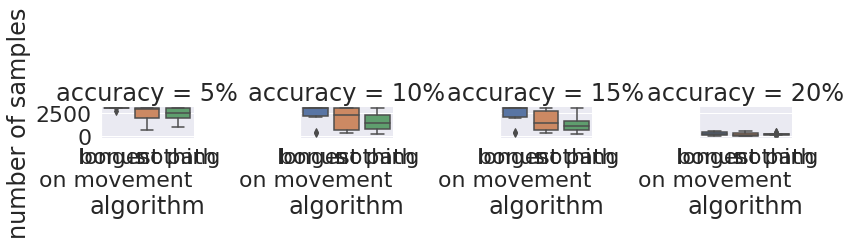

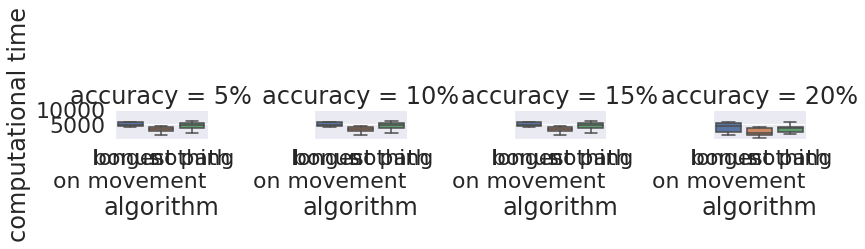

In [14]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/are_limonipes_easy_2/",
            "/home/leni/are-logs/are_limonipes_easy/",
            "/home/leni/are-logs/are_nipes_easy/"]
type_exp = ["bonus \non movement","longest path","nothing"]
maze_name =  ["easy race"]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "nipes") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 3000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 3000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 3000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",type_exp[i]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","algorithm"])    
    
ax1 = sns.catplot(x="algorithm",y="number of samples",col="accuracy",data=d,kind="box",aspect=1,height=3)
ax2 = sns.catplot(x="algorithm",y="computational time",col="accuracy",data=d,kind="box",aspect=1,height=3)
ax2.set(ylim=[1,10000])

nipes_26_4_16-3-54-4074_2058271325


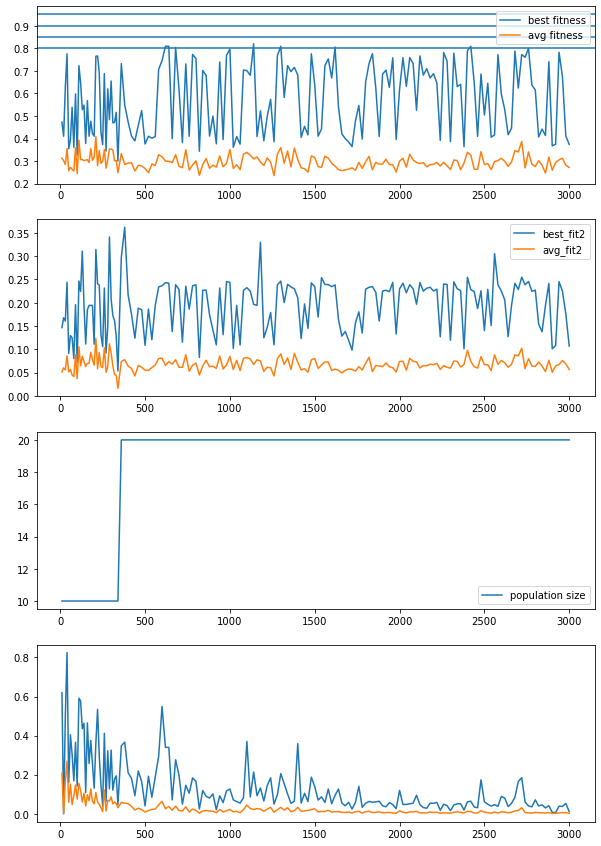

NameError: name 'are_ipop_hard_pst005' is not defined

In [32]:
are_limonipes_easy = "/home/leni/are-logs/are_limonipes_easy/"
x_vec = []
y_vec = []
for folder in os.listdir(are_limonipes_easy) :
    if(not os.path.isdir(are_limonipes_easy + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",0)
    neval, best_fit2, avg_fit2, pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",1)
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",2)
    nbeval, eval_time = load_eval_time(are_limonipes_easy + folder + "/eval_durations.csv");

    
    gain = [(best_fit[i] - best_fit[i-1])/eval_time[i-1] for i in range(1,len(best_fit))]

    fig = plt.figure(figsize=[10,15])
    ax1 = fig.add_subplot(4,1,1)
    ax2 = fig.add_subplot(4,1,3)
    ax3 = fig.add_subplot(4,1,2)
    ax4 = fig.add_subplot(4,1,4)

#    ax1.set_ylim(0.4,1)
#    ax3.set_ylim(0.0,0.5)
    ax1.plot(neval,best_fit,label="best fitness")
    
    ax1.plot(neval,avg_fit,label="avg fitness")
    ax1.axhline(y=0.95)
    ax1.axhline(y=0.9)
    ax1.axhline(y=0.85)
    ax1.axhline(y=0.80)
    
    ax2.plot(neval,pop_size,label="population size")
    ax4.plot(neval,best_nov,label="best_nov")
    ax4.plot(neval,avg_nov,label="avg_nov")
    ax3.plot(neval,best_fit2,label="best_fit2")
    ax3.plot(neval,avg_fit2,label="avg_fit2")
   # ax5.plot(eval_durations)

    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()
    animation_pop(are_ipop_hard_pst005 + folder,pop_size,1)

nipes_26_4_16-3-54-4074_2058271325


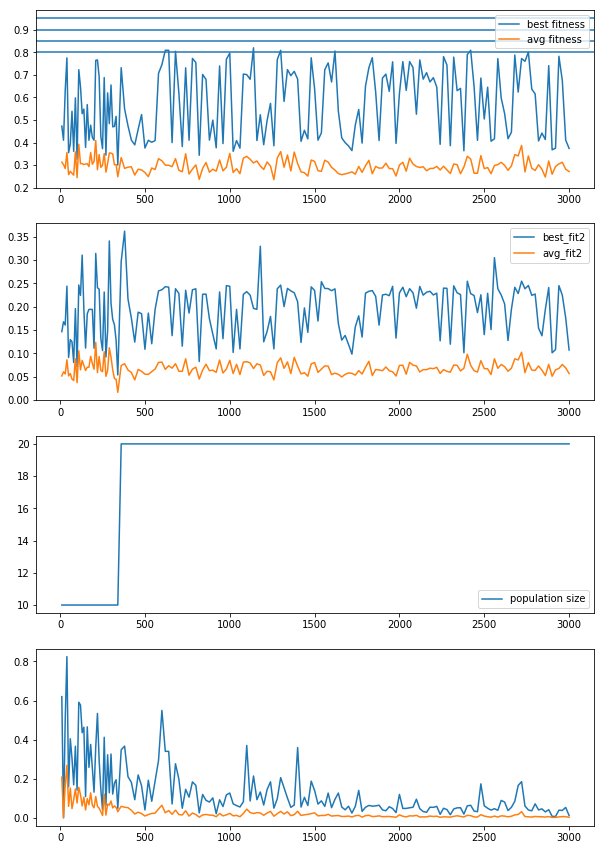

NameError: name 'are_ipop_hard_pst005' is not defined

In [4]:
are_limonipes_easy = "/home/leni/are-logs/are_limonipes_easy/"
x_vec = []
y_vec = []
for folder in os.listdir(are_limonipes_easy) :
    if(not os.path.isdir(are_limonipes_easy + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",0)
    neval, best_fit2, avg_fit2, pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",1)
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(are_limonipes_easy + folder + "/fitnesses.csv",2)
    nbeval, eval_time = load_eval_time(are_limonipes_easy + folder + "/eval_durations.csv");

    
    gain = [(best_fit[i] - best_fit[i-1])/eval_time[i-1] for i in range(1,len(best_fit))]

    fig = plt.figure(figsize=[10,15])
    ax1 = fig.add_subplot(4,1,1)
    ax2 = fig.add_subplot(4,1,3)
    ax3 = fig.add_subplot(4,1,2)
    ax4 = fig.add_subplot(4,1,4)

#    ax1.set_ylim(0.4,1)
#    ax3.set_ylim(0.0,0.5)
    ax1.plot(neval,best_fit,label="best fitness")
    
    ax1.plot(neval,avg_fit,label="avg fitness")
    ax1.axhline(y=0.95)
    ax1.axhline(y=0.9)
    ax1.axhline(y=0.85)
    ax1.axhline(y=0.80)
    
    ax2.plot(neval,pop_size,label="population size")
    ax4.plot(neval,best_nov,label="best_nov")
    ax4.plot(neval,avg_nov,label="avg_nov")
    ax3.plot(neval,best_fit2,label="best_fit2")
    ax3.plot(neval,avg_fit2,label="avg_fit2")
   # ax5.plot(eval_durations)

    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()
    animation_pop(are_ipop_hard_pst005 + folder,pop_size,1)

Longest path as second objective
/home/leni/are-logs/tri_nipes_escape/
5% 323.0 192.66810841444413 574.1388985681999 308.70412382835934
10% 94.0 89.68834929911465 574.1388985681999 308.70412382835934
15% 86.0 78.2559901860554 574.1388985681999 308.70412382835934
20% 56.0 62.80127387243033 574.1388985681999 308.70412382835934
/home/leni/are-logs/tri_nipes_middle/
5% 868.0 577.7335025770965 1219.2083501536003 702.598320345494
10% 238.0 165.21501142450705 1219.2083501536003 702.598320345494
15% 120.0 72.80109889280519 1219.2083501536003 702.598320345494
20% 66.0 53.88877434122992 1219.2083501536003 702.598320345494
/home/leni/are-logs/tri_nipes_multi/
5% 185.0 120.7683733433551 331.348981198 185.9867019368255
10% 83.0 52.354560450833695 331.348981198 185.9867019368255
15% 44.0 45.43126676640219 331.348981198 185.9867019368255
20% 11.0 3.0 331.348981198 185.9867019368255
/home/leni/are-logs/tri_nipes_easy/
5% 3017.0 13.45362404707371 4124.418848316401 297.7078369695451
10% 3017.0 13.453624

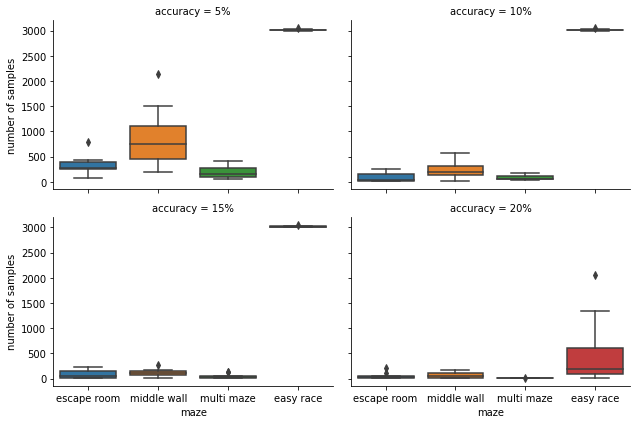

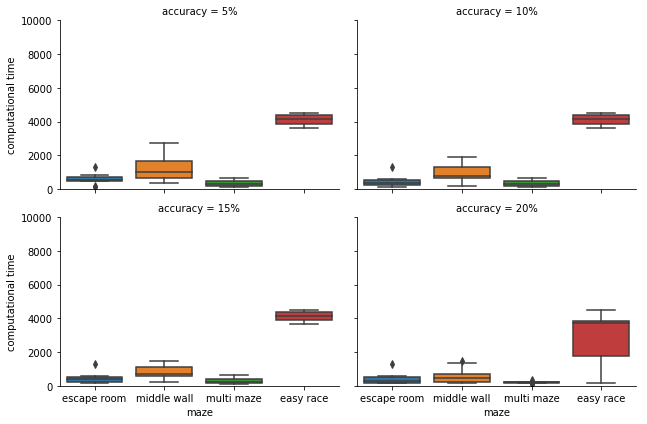

In [12]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/tri_nipes_escape/",
            "/home/leni/are-logs/tri_nipes_middle/",
            "/home/leni/are-logs/tri_nipes_multi/",
           "/home/leni/are-logs/tri_nipes_easy/"]
type_exp = ["nipes"]
maze_name =  ["escape room","middle wall","multi maze","easy race"]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "nipes") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 3000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 3000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 3000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",maze_name[i]])
        lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",maze_name[i]])
        lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",maze_name[i]])
        lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",maze_name[i]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","maze"])    
    
ax1 = sns.catplot(x="maze",y="number of samples",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
ax2 = sns.catplot(x="maze",y="computational time",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
ax2.set(ylim=[1,10000])

nipes_3_5_10-28-54-4834_3377969416


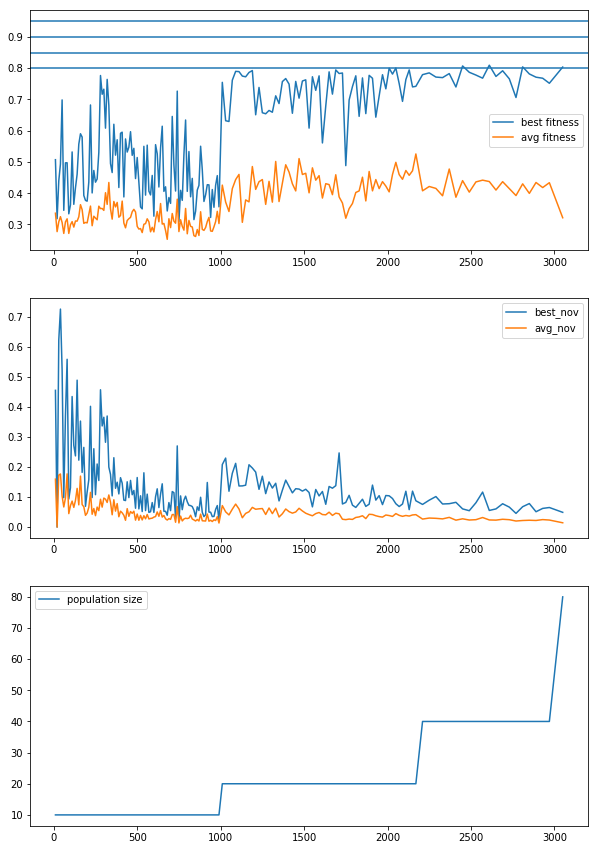

nipes_3_5_10-28-38-8583_2565297775


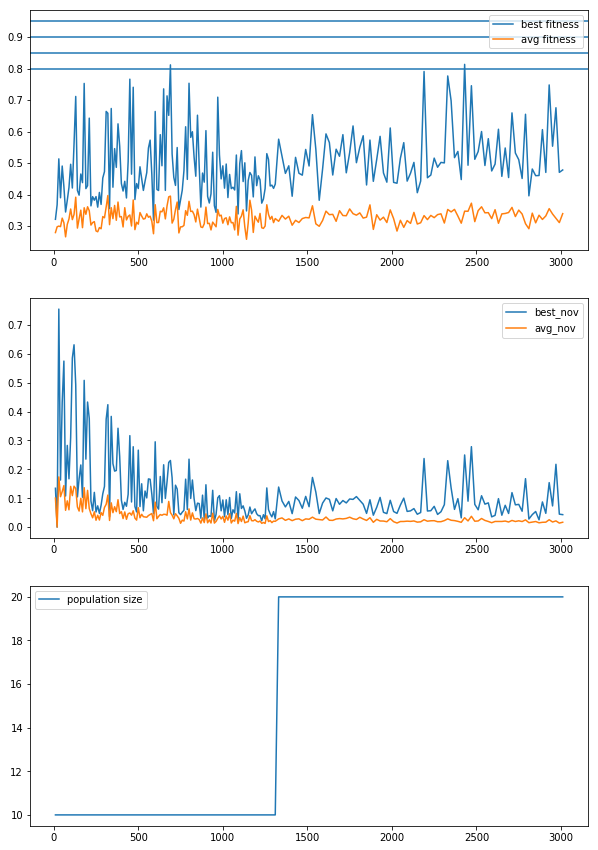

nipes_3_5_10-28-29-9474_4013177430


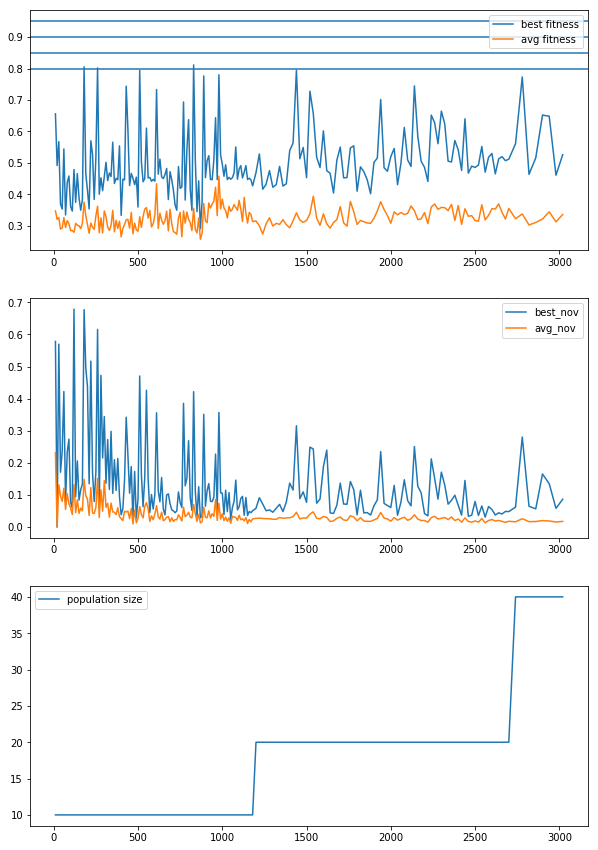

nipes_3_5_10-28-36-6589_3870579081


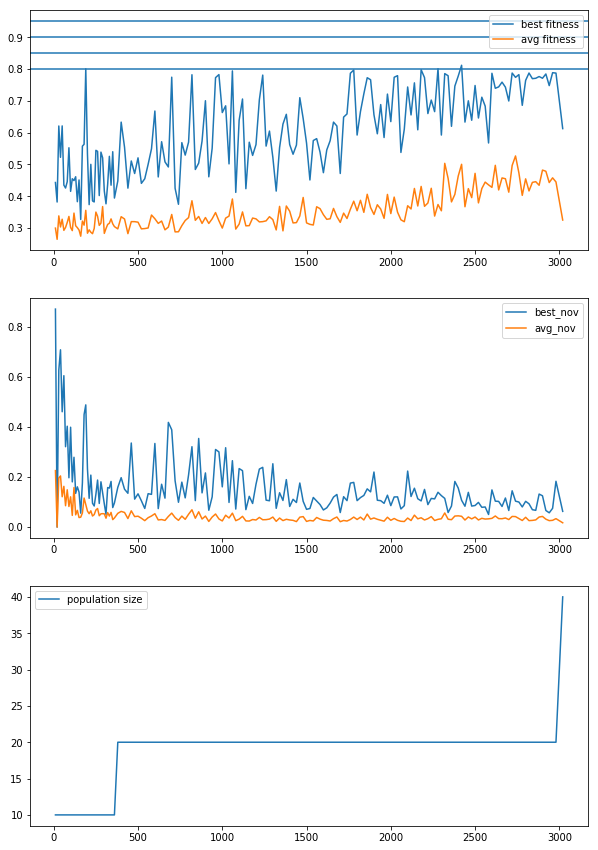

nipes_3_5_10-28-54-4470_1296050072


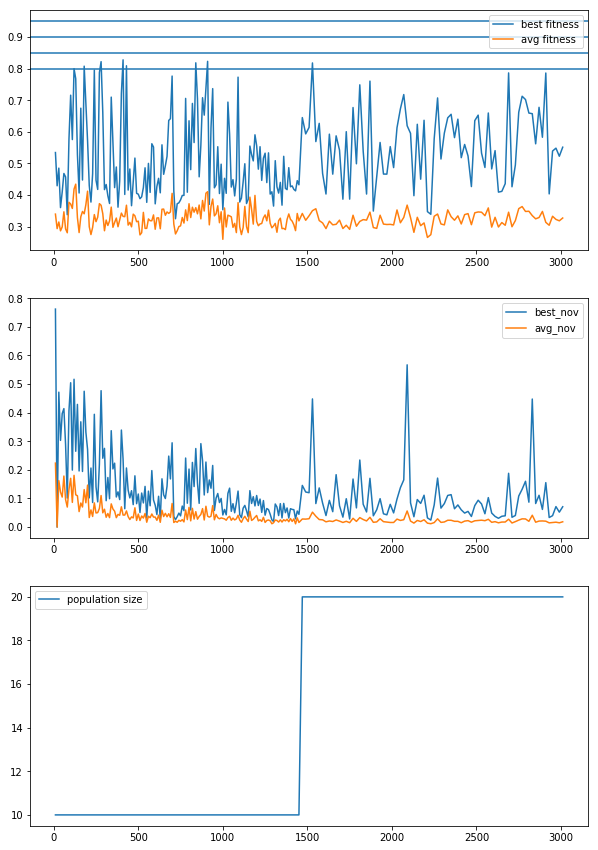

nipes_3_5_10-28-35-5758_610300820


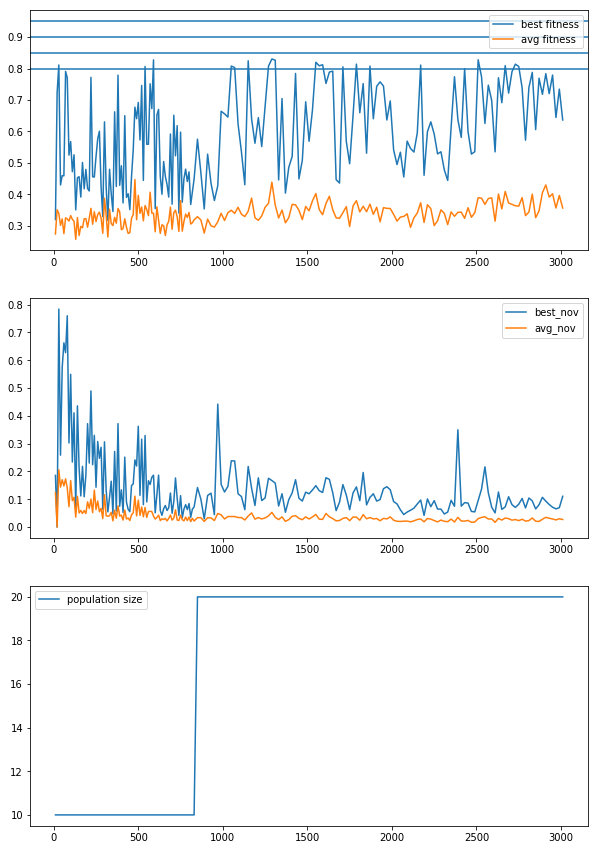

nipes_3_5_10-28-42-2707_2128161569


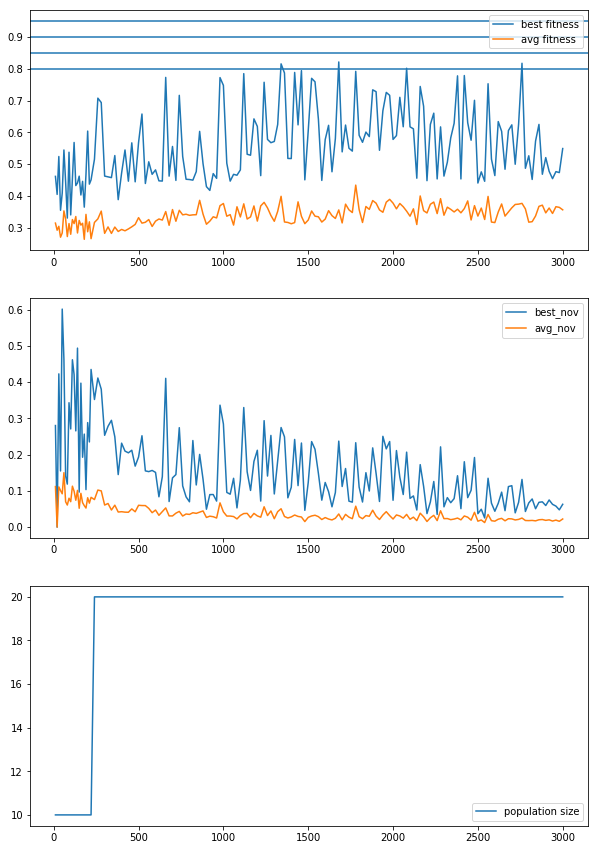

nipes_3_5_10-28-25-5285_72882685


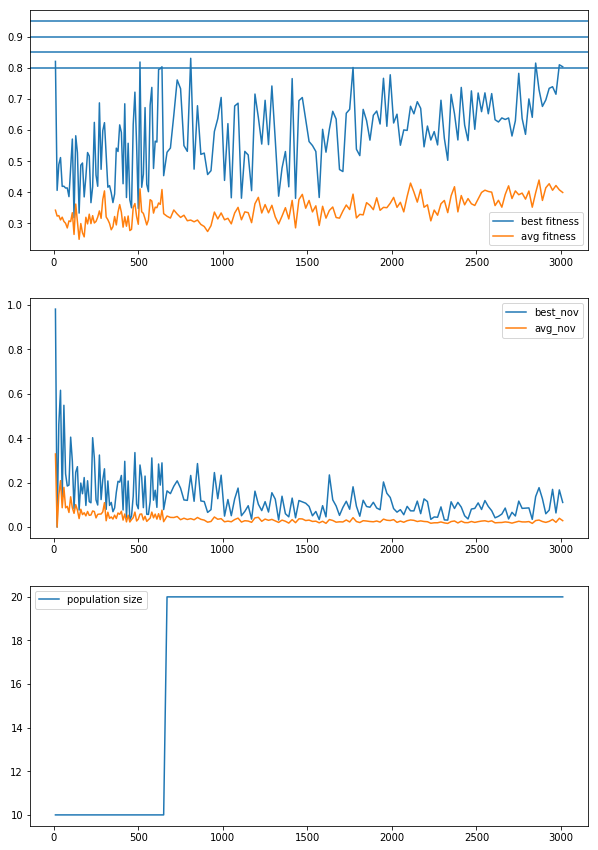

nipes_3_5_10-28-36-6683_582414975


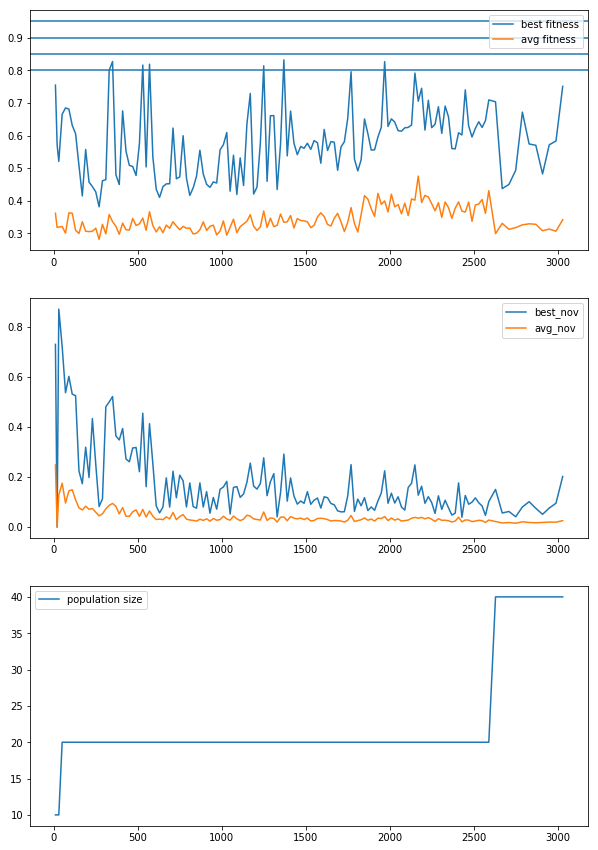

nipes_3_5_10-28-52-2836_1860162601


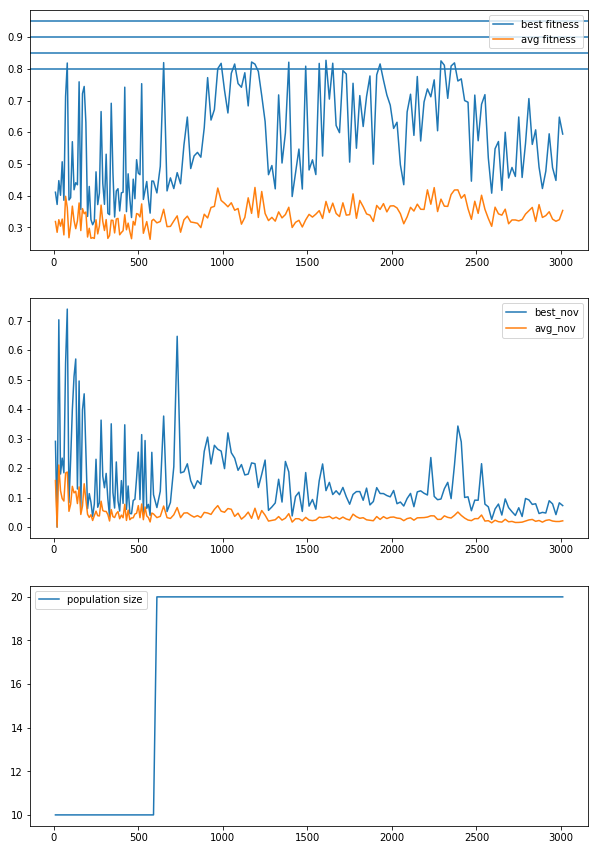

In [4]:
tri_nipes_easy = "/home/leni/are-logs/tri_nipes_easy/"
x_vec = []
y_vec = []
for folder in os.listdir(tri_nipes_easy) :
    if(not os.path.isdir(tri_nipes_easy + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(tri_nipes_easy + folder + "/fitnesses.csv",0)
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(tri_nipes_easy + folder + "/fitnesses.csv",1)
    nbeval, eval_time = load_eval_time(tri_nipes_easy + folder + "/eval_durations.csv");

    
    gain = [(best_fit[i] - best_fit[i-1])/eval_time[i-1] for i in range(1,len(best_fit))]

    fig = plt.figure(figsize=[10,15])
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,3)
    ax3 = fig.add_subplot(3,1,2)
    #ax4 = fig.add_subplot(4,1,4)

#    ax1.set_ylim(0.4,1)
#    ax3.set_ylim(0.0,0.5)
    ax1.plot(neval,best_fit,label="best fitness")
    
    ax1.plot(neval,avg_fit,label="avg fitness")
    ax1.axhline(y=0.95)
    ax1.axhline(y=0.9)
    ax1.axhline(y=0.85)
    ax1.axhline(y=0.80)
    
    ax2.plot(neval,pop_size,label="population size")
    ax3.plot(neval,best_nov,label="best_nov")
    ax3.plot(neval,avg_nov,label="avg_nov")

   # ax5.plot(eval_durations)

    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()
    #animation_pop(tri_nipes_easy + folder,pop_size,1)

Longest path as second objective
/home/leni/are-logs/are_nipes_hard_t01/
5% 10122.0 92.6066952223218 15851.847523811197 799.9267177577743
10% 10122.0 92.6066952223218 15851.847523811197 799.9267177577743
15% 2589.0 2848.8890817299293 15851.847523811197 799.9267177577743
20% 1660.0 1469.5237323704575 15851.847523811197 799.9267177577743
/home/leni/are-logs/tri_nipes_easy_t01/
5% 10127.777777777777 83.7692303332034 13097.734420595332 898.8552953471656
10% 10127.777777777777 83.7692303332034 13097.734420595332 898.8552953471656
15% 10127.777777777777 83.7692303332034 13097.734420595332 898.8552953471656
20% 324.44444444444446 224.99931412789837 13097.734420595332 898.8552953471656


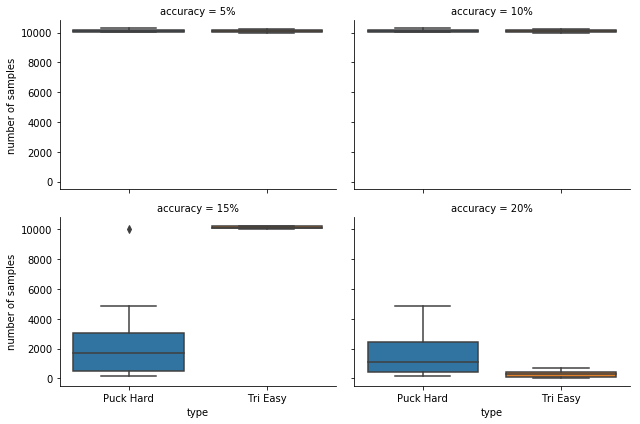

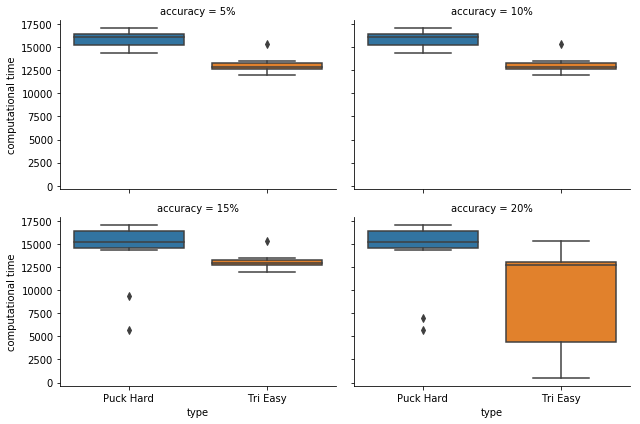

In [4]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/are_nipes_hard_t01/",
           "/home/leni/are-logs/tri_nipes_easy_t01/"]
type_exp = ["Puck Hard","Tri Easy"]
#maze_name =  ["escape room","middle wall","multi maze","easy race"]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "nipes") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 10000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 10000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 10000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",type_exp[i]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","type"])    
    
ax1 = sns.catplot(x="type",y="number of samples",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
ax2 = sns.catplot(x="type",y="computational time",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

Longest path as second objective
/home/leni/are-logs/are_nipes_hard_t01/
5% 10122.0 92.6066952223218 15851.847523811197 799.9267177577743
10% 10122.0 92.6066952223218 15851.847523811197 799.9267177577743
15% 2589.0 2848.8890817299293 15851.847523811197 799.9267177577743
20% 1660.0 1469.5237323704575 15851.847523811197 799.9267177577743
/home/leni/are-logs/are_nipes_easy_t01/
5% 6578.0 3476.9751221428087 11849.8081818907 5647.185530058386
10% 3780.0 3370.6557225560728 11849.8081818907 5647.185530058386
15% 3286.0 3143.769075488847 11849.8081818907 5647.185530058386
20% 321.0 128.33160171991932 11849.8081818907 5647.185530058386
/home/leni/are-logs/are_nipes_multi_t01/
5% 1967.0 2798.2210420193755 3091.0330940450003 3705.2610777739746
10% 261.0 194.65096968677037 3091.0330940450003 3705.2610777739746
15% 13.0 4.58257569495584 3091.0330940450003 3705.2610777739746
20% 11.0 3.0 3091.0330940450003 3705.2610777739746


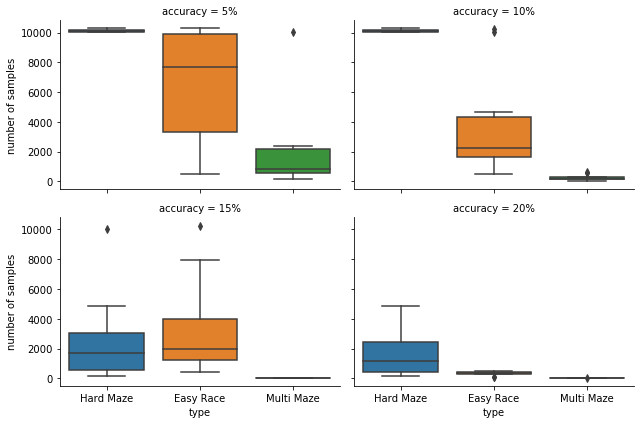

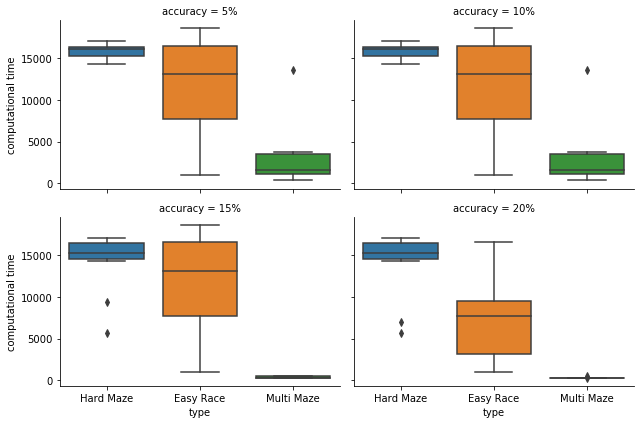

In [4]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/are_nipes_hard_t01/",
           "/home/leni/are-logs/are_nipes_easy_t01/",
           "/home/leni/are-logs/are_nipes_multi_t01/"]
type_exp = ["Hard Maze","Easy Race","Multi Maze"]
#maze_name =  ["escape room","middle wall","multi maze","easy race"]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "nipes") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 10000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 10000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 10000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",type_exp[i]])
        lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",type_exp[i]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","type"])    
    
ax1 = sns.catplot(x="type",y="number of samples",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
ax2 = sns.catplot(x="type",y="computational time",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

/home/leni/are-logs/are_nipes_escape_beacon/
5% 13.0 6.4031242374328485 47.8110448775 19.6444934296163
10% 11.0 3.0 47.8110448775 19.6444934296163
15% 11.0 3.0 47.8110448775 19.6444934296163
20% 10.0 0.0 47.8110448775 19.6444934296163
/home/leni/are-logs/tri_nipes_escape_beacon/
5% 137.0 84.97646733066749 353.585455622 214.22412700414233
10% 48.0 49.35585071701227 353.585455622 214.22412700414233
15% 31.0 22.11334438749598 353.585455622 214.22412700414233
20% 23.0 11.874342087037917 353.585455622 214.22412700414233
/home/leni/are-logs/are_nipes_middle_beacon/
5% 264.5 271.449350708378 732.3914114886 616.5504253876521
10% 184.0 159.3549497191725 732.3914114886 616.5504253876521
15% 69.5 58.862127042776834 732.3914114886 616.5504253876521
20% 51.0 55.308227236099334 732.3914114886 616.5504253876521
/home/leni/are-logs/tri_nipes_middle_beacon/
5% 535.0 560.4774750157227 1085.2233680421 977.5468654885182
10% 173.0 200.1024737478275 1085.2233680421 977.5468654885182
15% 99.0 90.437823945515

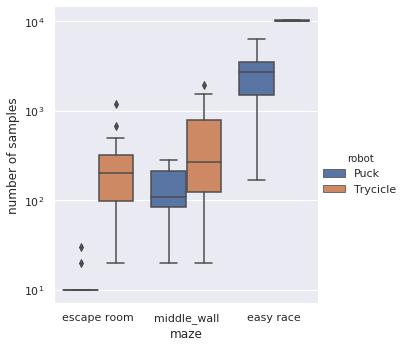

In [46]:

sns.set(rc={'figure.figsize':(20,8)})
list_dir = ["/home/leni/are-logs/are_nipes_escape_beacon/",
           "/home/leni/are-logs/tri_nipes_escape_beacon/",
            "/home/leni/are-logs/are_nipes_middle_beacon/",
            "/home/leni/are-logs/tri_nipes_middle_beacon/",
           "/home/leni/are-logs/are_nipes_easy_beacon/",
           "/home/leni/are-logs/tri_nipes_easy_beacon/"]
type_exp = ["Puck","Trycicle"]
maze_name =  ["escape room","middle_wall","easy race"]
idx = [[0,0],[0,1],[1,0],[1,1],[0,2],[1,2]]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "nipes") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 10000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 10000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 10000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
       # lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        #lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        #lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","robot","maze"])    
    
ax1 = sns.catplot(x="maze",y="number of samples",hue="robot",data=d,kind="box")
ax1.set(yscale="log")
#ax2 = sns.catplot(x="maze",y="computational time",hue="type",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

In [20]:

sns.set(rc={'figure.figsize':(20,8)})
list_dir = ["/home/leni/are-logs/are_ipop_escape/",
            "/home/leni/are-logs/are_ipop_middle/",
           "/home/leni/are-logs/are_ipop_easy/"]
type_exp = ["Puck"]
maze_name =  ["escape room","middle_wall","easy race"]
idx = [[0,0],[0,1],[0,2]]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or folder.split("_")[0] != "ipop") :
            continue
            
        neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
        nbeval, eval_time = load_eval_time(dire + folder + "/eval_durations.csv")
        neval_10 = 0
        neval_15 = 0
        neval_20 = 0
        neval_list.append(neval[-1])

        time_list.append(sum(eval_time))
        for fit,ne in zip(best_fit,neval) :
            if(fit >= 0.90 or ne >= 10000) :
                neval_10 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.85 or ne >= 10000) :
                neval_15 = ne
                break
        for fit,ne in zip(best_fit,neval) :        
            if(fit >= 0.8 or ne >= 10000) :
                neval_20 = ne
                break
        neval_list_10.append(neval_10)
        neval_list_15.append(neval_15)
        neval_list_20.append(neval_20)
        lines.append([sum(eval_time),neval[-1],"5%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
       # lines.append([sum(eval_time[:int(neval_10)]),neval_10,"10%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        lines.append([sum(eval_time[:int(neval_15)]),neval_15,"15%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        #lines.append([sum(eval_time[:int(neval_20)]),neval_20,"20%",type_exp[idx[i][0]],maze_name[idx[i][1]]])
        
    print("5%",np.mean(neval_list),np.std(neval_list),np.mean(time_list),np.std(time_list))
    print("10%",np.mean(neval_list_10),np.std(neval_list_10),np.mean(time_list),np.std(time_list))
    print("15%",np.mean(neval_list_15),np.std(neval_list_15),np.mean(time_list),np.std(time_list))
    print("20%",np.mean(neval_list_20),np.std(neval_list_20),np.mean(time_list),np.std(time_list))
    i+=1
    
d = pd.DataFrame(data=lines,columns=["computational time","number of samples","accuracy","robot","maze"])    
    
ax1 = sns.catplot(x="maze",y="number of samples",hue="robot",col="accuracy",data=d,kind="box")
ax1.set(yscale="log")
#ax2 = sns.catplot(x="maze",y="computational time",hue="type",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

/home/leni/are-logs/are_ipop_escape/


ValueError: invalid literal for int() with base 10: '0.539337'

nipes_18_5_15-46-20-221_74300107
10 0.829925 0.386072
20 0.714197 0.0
30 0.809326 0.22949
40 0.861289 0.210523
50 0.95096 0.0602129
60 0.745693 0.209868
70 0.826701 0.481769
80 0.956815 0.1623
90 0.804705 0.0
100 0.989084 0.0893577
110 0.984554 0.0
120 0.988019 0.0752025
130 0.990282 0.0
140 0.994496 0.0
150 0.99615 0.119811
160 0.989419 0.323774
170 0.985841 0.0
180 0.967172 0.0792878
190 0.945212 0.0
200 0.817071 0.105163
210 0.996191 0.0
220 0.984583 0.129028
230 0.995067 0.0
240 0.991556 0.0
250 0.993756 0.0
260 0.99394 0.0
270 0.957382 0.132864
280 0.995147 0.0
290 0.994979 0.0
310 0.996165 0.0
330 0.993123 0.0
350 0.991793 0.00178559
370 0.992512 0.0
390 0.9905 0.0
410 0.985358 0.0
430 0.983675 0.0
450 0.99594 0.0
470 0.990016 0.0112315
490 0.987251 0.0
510 0.977893 0.0663908
530 0.986244 0.0387737
550 0.9273 0.00383722
570 0.993779 0.0
590 0.782739 0.275911
610 0.988544 0.0
630 0.97848 0.0955266
650 0.986768 0.0
670 0.995695 0.423882
690 0.993623 0.172802
730 0.996384 0.0
770 0.

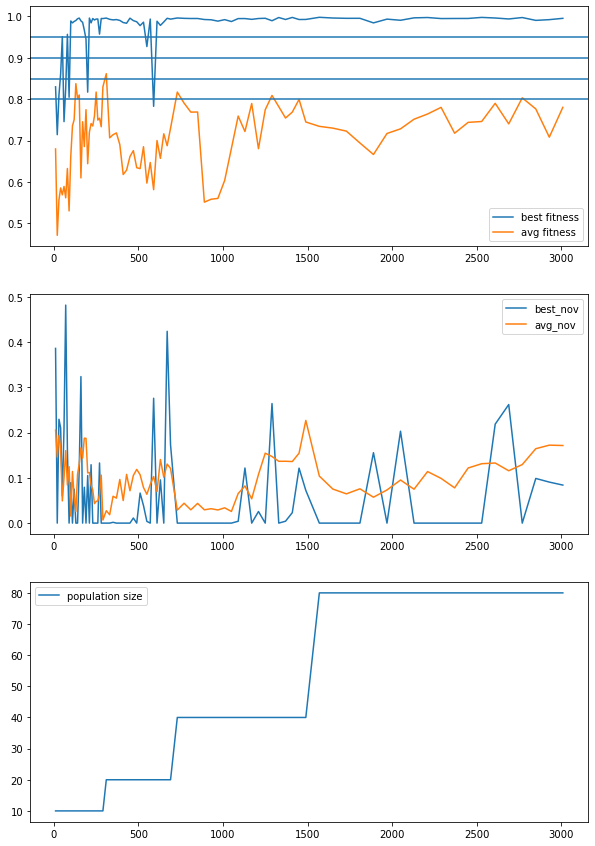

nipes_18_5_15-45-50-197_966628745
10 0.843379 0.0
20 0.761398 0.135784
30 0.775719 0.0
40 0.977315 0.491931
50 0.776046 0.100129
60 0.770473 0.156375
70 0.92298 0.123008
80 0.807489 0.0899353
90 0.963771 0.261104
100 0.971165 0.0708105
110 0.964313 0.316941
120 0.923753 0.0232635
130 0.972421 0.271446
140 0.981427 0.0520101
150 0.996406 0.0
160 0.994718 0.138895
170 0.990132 0.184364
180 0.979106 0.195825
190 0.983757 0.090142
200 0.987755 0.281346
210 0.980479 0.121052
220 0.98151 0.0317911
230 0.990212 0.192855
240 0.988847 0.234413
250 0.839466 0.0764501
260 0.983735 0.191666
270 0.974518 0.0474013
280 0.972806 0.387341
300 0.981088 0.0637872
320 0.827893 0.0
340 0.980624 0.128991
360 0.988298 0.302155
380 0.973441 0.138069
400 0.958051 0.0
420 0.984516 0.0
440 0.99378 0.000860715
460 0.97962 0.0
480 0.992222 0.191367
500 0.977299 0.11728
520 0.99102 0.243565
540 0.981267 0.0
560 0.993206 0.135134
580 0.993228 0.0558375
600 0.991079 0.0272065
620 0.97987 0.00223817
640 0.97669 0.009

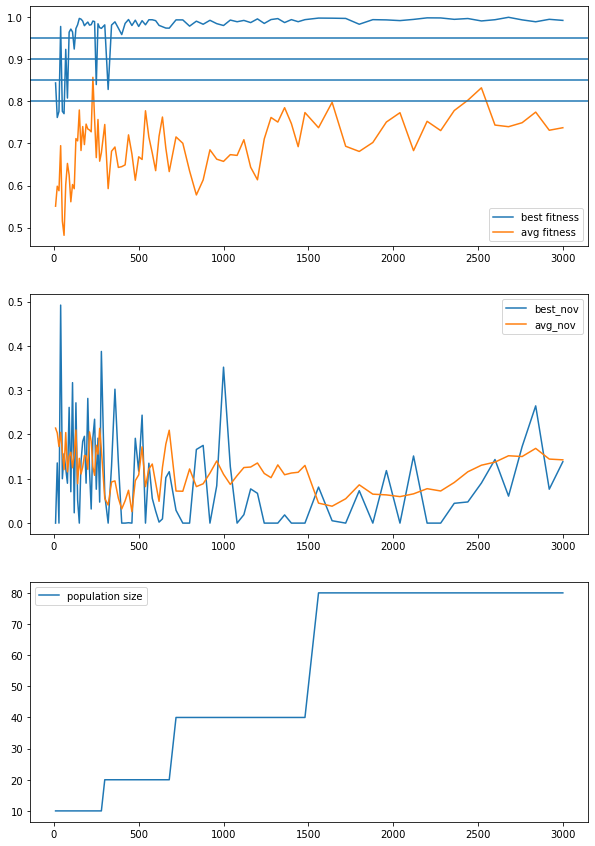

nipes_18_5_15-46-18-8382_666588014
10 0.988629 0.317205
20 0.839374 0.287081
30 0.900154 0.335828
40 0.929177 0.460171
50 0.956032 0.0
60 0.780387 0.162858
70 0.979956 0.268832
80 0.684194 0.26468
90 0.988349 0.0
100 0.987215 0.185047
110 0.827357 0.218907
120 0.98758 0.0224098
130 0.964135 0.00257757
140 0.975837 0.227849
150 0.788194 0.425168
160 0.989571 0.175338
170 0.985149 0.0522335
180 0.918995 0.0
190 0.766558 0.0
200 0.94906 0.0
210 0.960978 0.0991712
220 0.761105 0.727173
230 0.987589 0.268303
240 0.96564 0.6131
250 0.994848 0.0
260 0.980819 0.260551
270 0.845353 0.0
280 0.990061 0.0
290 0.99467 0.146083
300 0.997906 0.0971669
310 0.953378 0.156143
320 0.992602 0.064467
330 0.988793 0.19483
340 0.985722 0.19119
350 0.970235 0.189104
360 0.985859 0.163391
370 0.992515 0.0495278
380 0.980367 0.146998
390 0.950258 0.0801147
400 0.954239 0.0363434
410 0.978467 0.040367
420 0.97751 0.123809
440 0.97989 0.0
460 0.992155 0.0
480 0.997006 0.0
500 0.99112 0.0
520 0.82453 0.0
540 0.758

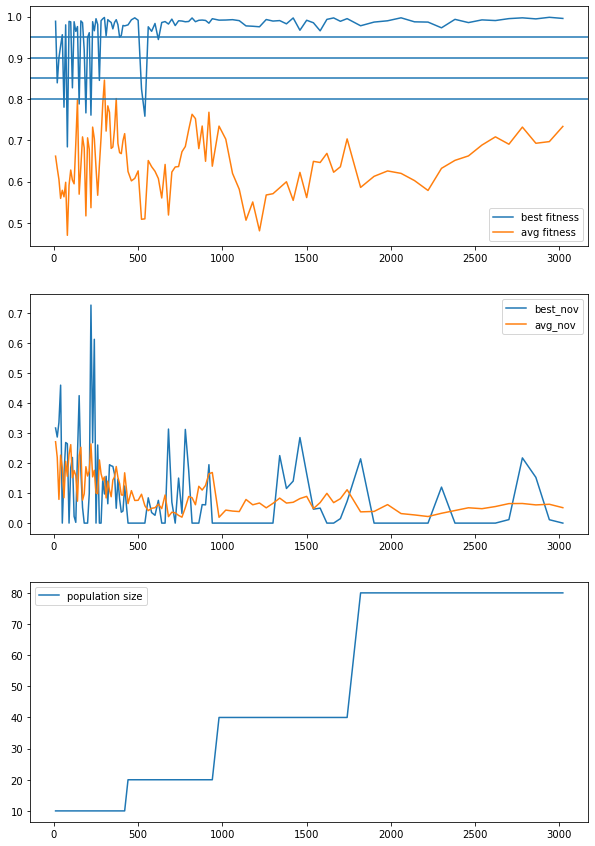

nipes_18_5_15-45-57-7771_880476967
10 0.98686 0.0
20 0.958087 0.678424
30 0.991271 0.197617
40 0.98527 0.272033
50 0.982254 0.303715
60 0.975086 0.183906
70 0.825984 0.377257
80 0.992401 0.0
90 0.993042 0.0
100 0.828047 0.475352
110 0.748005 0.0
120 0.751384 0.0
130 0.676716 0.0
140 0.825785 0.0
150 0.953662 0.221506
160 0.984478 0.521518
170 0.886424 0.190953
180 0.766472 0.329469
190 0.782687 0.391037
200 0.97915 0.512927
210 0.791209 0.490266
220 0.821364 0.0
230 0.957521 0.317954
240 0.935387 0.0
250 0.986738 0.505487
260 0.960033 0.108916
270 0.916714 0.0966823
280 0.931519 0.0898713
290 0.966528 0.0848439
300 0.952668 0.0731308
310 0.699674 0.0
320 0.944943 0.0
330 0.768182 0.30813
340 0.868707 0.242235
350 0.768576 0.0
360 0.961821 0.161377
370 0.922898 0.0
380 0.924913 0.0
390 0.970561 0.309568
400 0.987877 0.0
410 0.790866 0.19034
420 0.933165 0.187172
430 0.822128 0.224857
440 0.987657 0.0
450 0.987868 0.0
460 0.992192 0.0
470 0.995419 0.0
480 0.995051 0.0
490 0.985327 0.2430

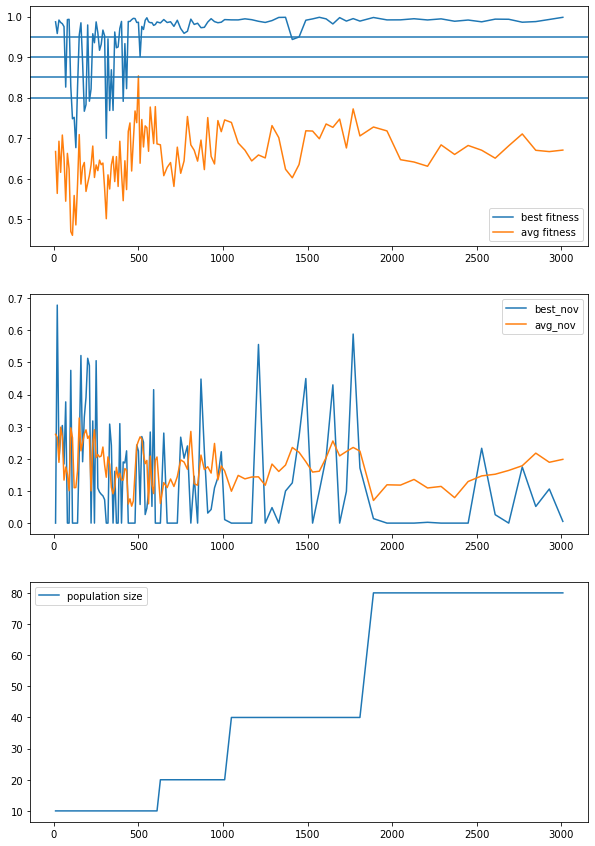

nipes_18_5_15-46-9-9428_2201888340
10 0.970537 0.340766
20 0.758295 0.448326
30 0.984395 0.142321
40 0.96396 0.126926
50 0.96776 0.106225
60 0.922978 0.169889
70 0.99514 0.0
80 0.984265 0.0
90 0.980213 0.0246462
100 0.984019 0.137038
110 0.831242 0.104926
120 0.821561 0.609024
130 0.94978 0.349414
140 0.978155 0.327541
150 0.98757 0.100941
160 0.99481 0.133182
170 0.948388 0.281598
180 0.984678 0.111691
190 0.982765 0.159414
200 0.985649 0.0269562
210 0.988455 0.233467
220 0.81962 0.353182
230 0.935197 0.302497
240 0.98749 0.0513026
250 0.990381 0.456163
260 0.993561 0.0902148
270 0.994125 0.0222063
280 0.984828 0.139611
290 0.984016 0.207888
300 0.981517 0.406672
310 0.97513 0.147026
320 0.972223 0.326398
340 0.962499 0.338057
360 0.99195 0.0
380 0.994894 0.0972923
400 0.966551 0.0633458
420 0.986964 0.0944863
440 0.99623 0.0
460 0.996607 0.0
480 0.98677 0.229599
500 0.987511 0.0887949
520 0.805976 0.304121
540 0.987944 0.232314
560 0.985208 0.0807017
580 0.993531 0.0
600 0.992478 0.2

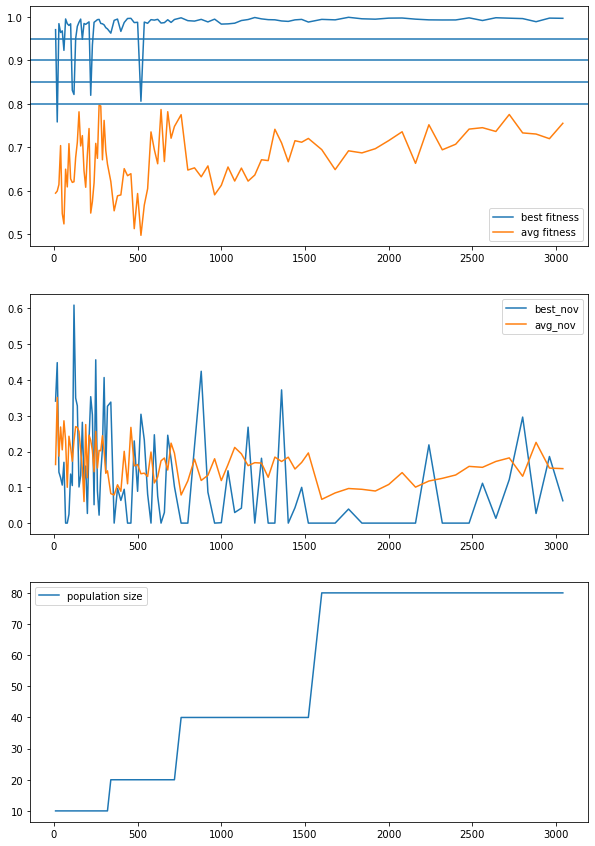

nipes_18_5_15-46-18-8611_1801652075
10 0.830394 0.405149
20 0.935375 0.489296
30 0.801565 0.277419
40 0.956833 0.312882
50 0.959856 0.0
60 0.932416 0.119767
70 0.989009 0.00889942
80 0.989966 0.0
90 0.989424 0.127402
100 0.991813 0.267216
110 0.943357 0.155061
120 0.967745 0.0
130 0.987126 0.0
140 0.942829 0.150875
150 0.987394 0.239677
160 0.983513 0.145821
170 0.984618 0.0257356
180 0.821348 0.0739833
190 0.981734 0.196367
200 0.804923 0.318185
210 0.986661 0.324808
220 0.975275 0.242145
230 0.994726 0.220981
240 0.98753 0.0913356
250 0.980638 0.325143
260 0.980218 0.168794
270 0.986628 0.0
280 0.991524 0.204
290 0.995427 0.148011
300 0.996134 0.0608435
310 0.995372 0.239592
320 0.985352 0.28683
330 0.987295 0.0548545
340 0.977349 0.0
350 0.988061 0.0
360 0.977904 0.158406
370 0.983276 0.192989
380 0.962705 0.0735917
400 0.996119 0.0
420 0.983908 0.0745554
440 0.992261 0.100248
460 0.826145 0.242967
480 0.978115 0.0520577
500 0.986224 0.103548
520 0.990891 0.120157
540 0.941856 0.037

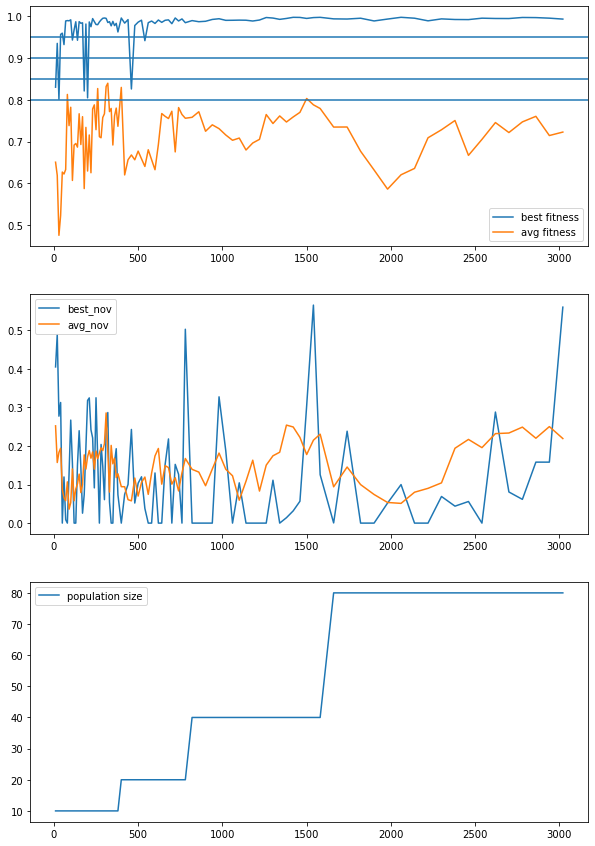

nipes_18_5_15-45-56-6547_1321825626
10 0.994529 0.183904
20 0.925495 0.322042
30 0.993388 0.0
40 0.991427 0.339512
50 0.994075 0.168688
60 0.970729 0.164676
70 0.969181 0.06022
80 0.981404 0.499075
90 0.700032 0.0562025
100 0.819367 0.296622
110 0.793825 0.427311
120 0.957805 0.310363
130 0.818262 0.10755
140 0.946822 0.721681
150 0.991593 0.432744
160 0.788898 0.345938
170 0.980191 0.0
180 0.986883 0.255323
190 0.775862 0.0
200 0.949751 0.302182
210 0.962558 0.0447822
220 0.981195 0.193176
230 0.979813 0.0758525
240 0.803333 0.0
250 0.828087 0.262021
260 0.993024 0.0
270 0.975514 0.216634
280 0.98491 0.0
290 0.980448 0.120743
300 0.965324 0.0354892
310 0.99375 0.066293
320 0.972355 0.115167
330 0.995597 0.0
340 0.986675 0.0
350 0.990982 0.0
360 0.992926 0.0
370 0.937134 0.0198023
380 0.970115 0.0
390 0.987122 0.0
400 0.990388 0.0
410 0.983901 0.0
420 0.993632 0.0
430 0.988241 0.0364622
440 0.980523 0.137781
460 0.996546 0.0
480 0.990753 0.0
500 0.988783 0.103329
520 0.962865 0.0540659

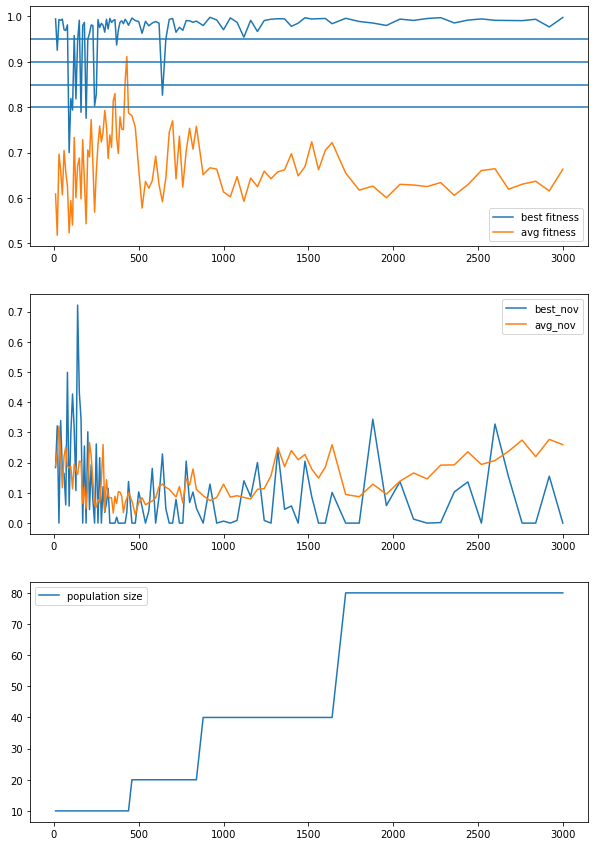

nipes_18_5_15-46-4-4503_3128366348
10 0.740789 0.00073922
20 0.797194 0.230321
30 0.793239 0.142602
40 0.688103 0.122795
50 0.876296 0.0
60 0.935392 0.548469
70 0.771938 0.113978
80 0.983237 0.0916594
90 0.937107 0.340852
100 0.993192 0.0
110 0.897806 0.158861
120 0.937023 0.210586
130 0.825541 0.141591
140 0.950726 0.0389987
150 0.994902 0.0
160 0.813249 0.140819
170 0.977515 0.325253
180 0.996986 0.298333
190 0.985549 0.0
200 0.985941 0.0817661
210 0.996635 0.0
220 0.954405 0.0
230 0.931384 0.109473
240 0.981252 0.0
250 0.994222 0.157991
260 0.987491 0.0343455
270 0.97957 0.167599
280 0.984615 0.164015
290 0.995732 0.0
300 0.982594 0.0555852
310 0.991563 0.138692
320 0.987274 0.0
330 0.985809 0.0
350 0.995742 0.0
370 0.992592 0.0177613
390 0.988169 0.314112
410 0.99302 0.0833339
430 0.982369 0.0
450 0.983614 0.317829
470 0.930271 0.194018
490 0.988403 0.0156753
510 0.986168 0.303155
530 0.989812 0.159473
550 0.989121 0.148519
570 0.985047 0.268906
590 0.983926 0.276475
610 0.939694 0

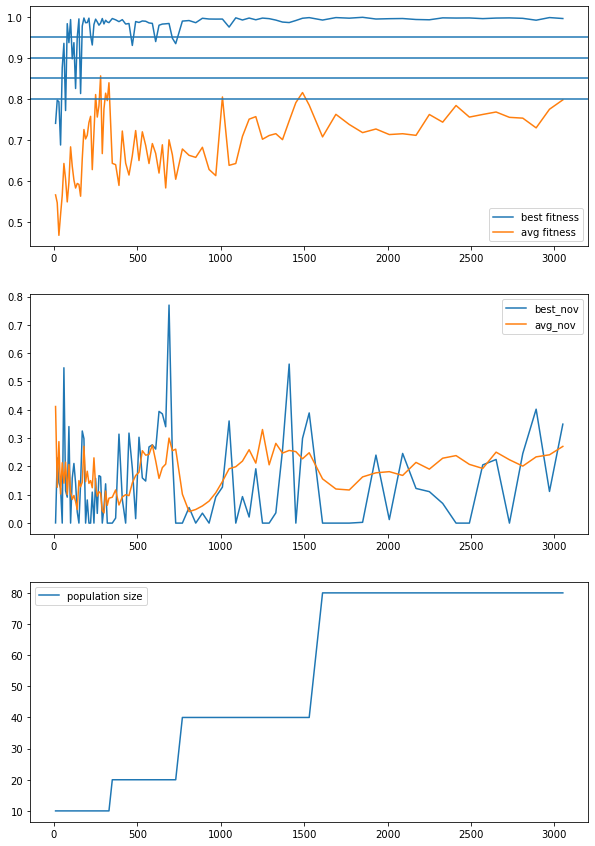

nipes_18_5_15-46-22-2373_3069596023
10 0.7903 0.196984
20 0.98528 0.273335
30 0.762709 0.286942
40 0.937218 0.407708
50 0.821933 0.375922
60 0.969877 0.307051
70 0.932893 0.0143558
80 0.97567 0.190668
90 0.986158 0.0
100 0.992751 0.0583882
110 0.991138 0.0
120 0.987976 0.0292094
130 0.935145 0.197588
140 0.978448 0.0
150 0.972391 0.5416
160 0.990188 0.102216
170 0.825805 0.0
180 0.872887 0.0
190 0.85313 0.0
200 0.984704 0.0
210 0.96587 0.105277
220 0.991126 0.0
230 0.991036 0.0
240 0.987788 0.0
250 0.983272 0.0
270 0.996605 0.0
290 0.991837 0.337707
310 0.975872 0.0
330 0.990752 0.0
350 0.937624 0.0
370 0.981643 0.19422
390 0.963966 0.044915
410 0.932466 0.0605644
430 0.990174 0.00379358
450 0.918733 0.0808272
470 0.989779 0.216844
490 0.944152 0.0
510 0.958331 0.00514222
530 0.9885 0.0
550 0.98426 0.578207
570 0.99487 0.0
590 0.994516 0.0
610 0.998303 0.0337568
630 0.993621 0.0780563
650 0.993257 0.134814
690 0.989144 0.0
730 0.984929 0.19185
770 0.991892 0.0
810 0.974569 0.0834779
85

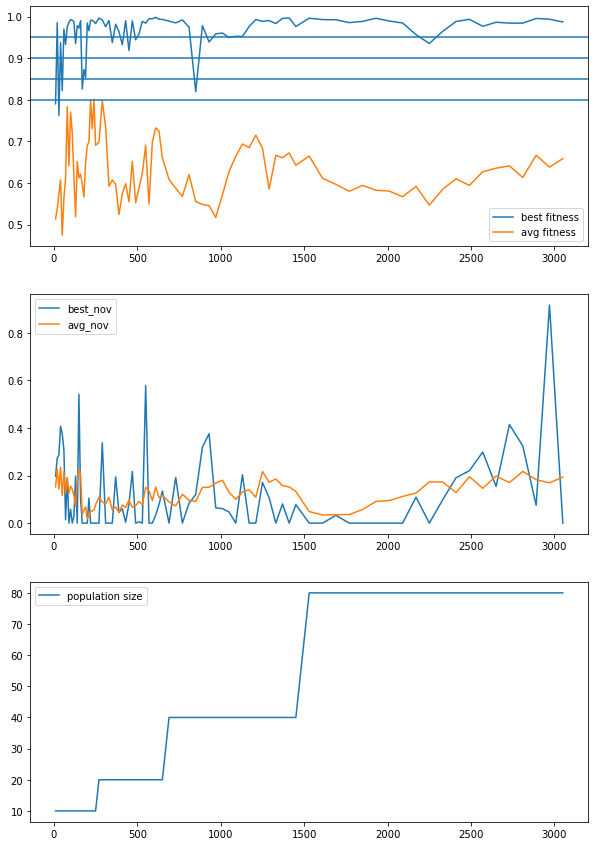

nipes_18_5_15-45-52-2031_4276213676
10 0.725334 0.436658
20 0.991242 0.103298
30 0.992115 0.128638
40 0.97537 0.64239
50 0.980319 0.165815
60 0.926482 0.23779
70 0.970717 0.0787174
80 0.978169 0.300546
90 0.989657 0.0
100 0.969395 0.320489
110 0.968529 0.327751
120 0.971998 0.453716
130 0.987256 0.0
140 0.97943 0.357364
150 0.978835 0.34006
160 0.958106 0.413471
170 0.985653 0.107417
180 0.987262 0.34753
190 0.995267 0.0300835
200 0.972741 0.304116
210 0.975723 0.0
230 0.996198 0.0
250 0.978463 0.0906382
270 0.994522 0.0271519
290 0.989174 0.0
310 0.985322 0.39234
330 0.997427 0.0
350 0.983971 0.120166
370 0.97402 0.38422
390 0.787414 0.155667
410 0.995088 0.0534778
430 0.971794 0.0742604
450 0.990966 0.0
470 0.989508 0.0
490 0.991108 0.587386
510 0.997384 0.0821372
530 0.993288 0.358834
550 0.955579 0.0
570 0.995499 0.465108
590 0.993275 0.0
610 0.99113 0.0
650 0.995448 0.0
690 0.991241 0.0
730 0.821558 0.156105
770 0.995197 0.0
810 0.808313 0.0
850 0.992014 0.0
890 0.986656 0.0
930 0

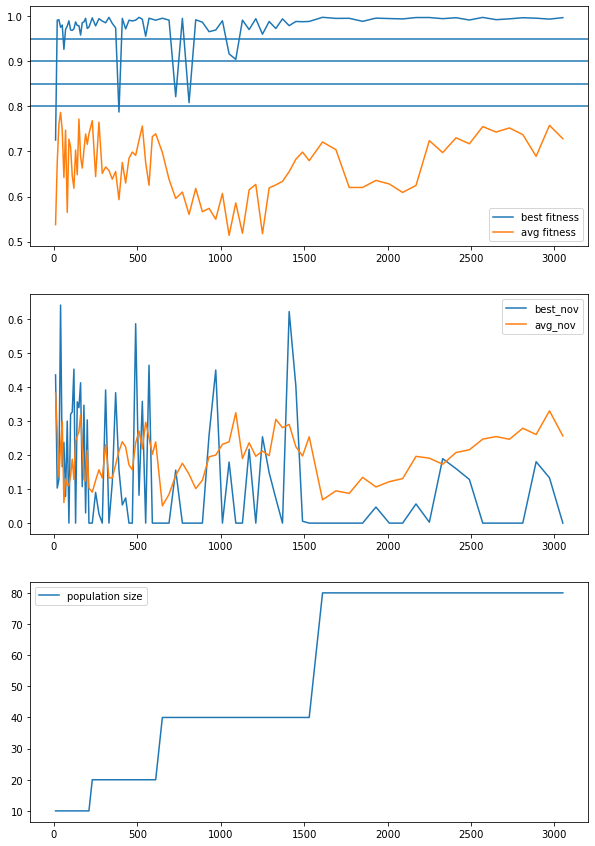

In [4]:
are_nipes_escape = "/home/leni/are-logs/are_nipes_escape_beacon_ec/"
x_vec = []
y_vec = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",0)
    neval, best_fit1, best_fit2,pop_size = load_best_fit_mo(are_nipes_escape + folder + "/fitnesses.csv")
    
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",1)
    nbeval, eval_time = load_eval_time(are_nipes_escape + folder + "/eval_durations.csv");

#    for n,obj1, obj2 in zip(neval,best_fit1,best_fit2) :
#        print(n,obj1,obj2)
    
    gain = [(best_fit[i] - best_fit[i-1])/eval_time[i-1] for i in range(1,len(best_fit))]

    fig = plt.figure(figsize=[10,15])
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,3)
    ax3 = fig.add_subplot(3,1,2)
    #ax4 = fig.add_subplot(4,1,4)

#    ax1.set_ylim(0.4,1)
#    ax3.set_ylim(0.0,0.5)
    ax1.plot(neval,best_fit1,label="best fitness")
    
    ax1.plot(neval,avg_fit,label="avg fitness")
    ax1.axhline(y=0.95)
    ax1.axhline(y=0.9)
    ax1.axhline(y=0.85)
    ax1.axhline(y=0.80)
    
    ax2.plot(neval,pop_size,label="population size")
    ax3.plot(neval,best_fit2,label="best_fit")
    ax3.plot(neval,avg_nov,label="avg_nov")

   # ax5.plot(eval_durations)

    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()
    #animation_pop(tri_nipes_easy + folder,pop_size,1)

nipes_18_5_15-59-21-1393_2800718732
nipes_18_5_15-59-16-6842_2903234012
nipes_18_5_15-59-28-8881_1243815690
nipes_18_5_17-20-20-339_3602060585
nipes_18_5_15-59-33-3311_1611400929
nipes_18_5_15-59-36-6101_2756097223
nipes_18_5_15-59-40-685_295114042
nipes_18_5_15-59-30-425_259170229
nipes_18_5_15-59-37-7445_1929098010
nipes_18_5_15-59-24-4220_1614130389


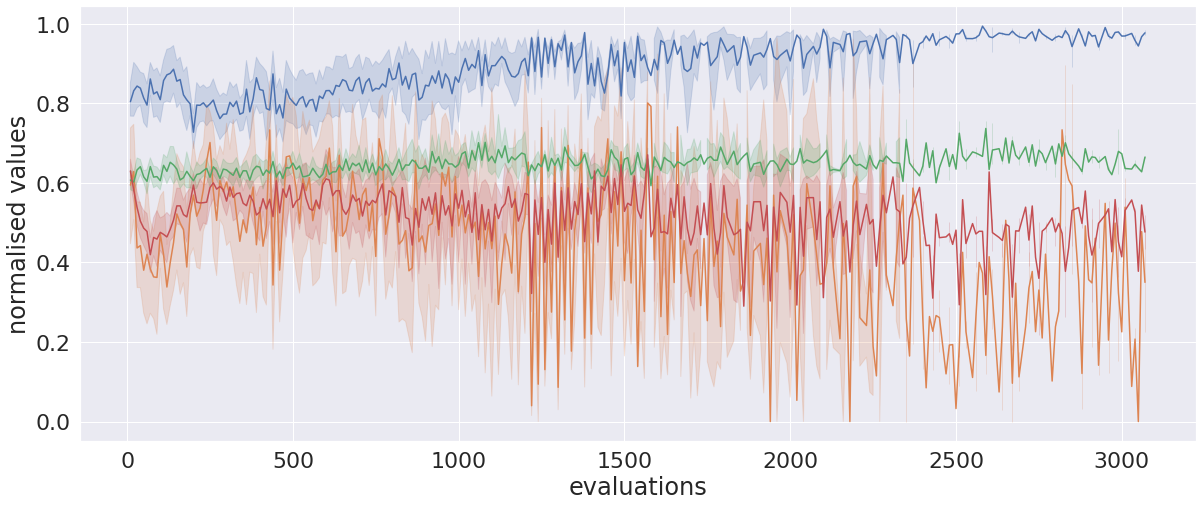

In [34]:
are_nipes_escape = "/home/leni/are-logs/tri_nipes_escape_beacon_ec/"
x_vec = []
y_vec = []
lines = []
sns.set(rc={'figure.figsize':(20,8)},font_scale=2)
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",0)
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",1)

    neval, best_fit1, best_fit2,pop_size = load_best_fit_mo(are_nipes_escape + folder + "/fitnesses.csv")
    nbeval, eval_time = load_eval_time(are_nipes_escape + folder + "/eval_durations.csv");

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],"best fitness"])
        lines.append([neval[i],best_fit2[i],"lower energy cost"])
        lines.append([neval[i],avg_fit[i],"average fitness"])
        lines.append([neval[i],avg_nov[i],"average energy cost"])


d = pd.DataFrame(data=lines,columns=["evaluations","normalised values","type"]) 
ax = sns.lineplot(x="evaluations",y="normalised values",hue="type",data=d,legend=False)

nipes_18_5_15-46-20-221_74300107
nipes_18_5_15-45-50-197_966628745
nipes_18_5_15-46-18-8382_666588014
nipes_18_5_15-45-57-7771_880476967
nipes_18_5_15-46-9-9428_2201888340
nipes_18_5_15-46-18-8611_1801652075
nipes_18_5_15-45-56-6547_1321825626
nipes_18_5_15-46-4-4503_3128366348
nipes_18_5_15-46-22-2373_3069596023
nipes_18_5_15-45-52-2031_4276213676


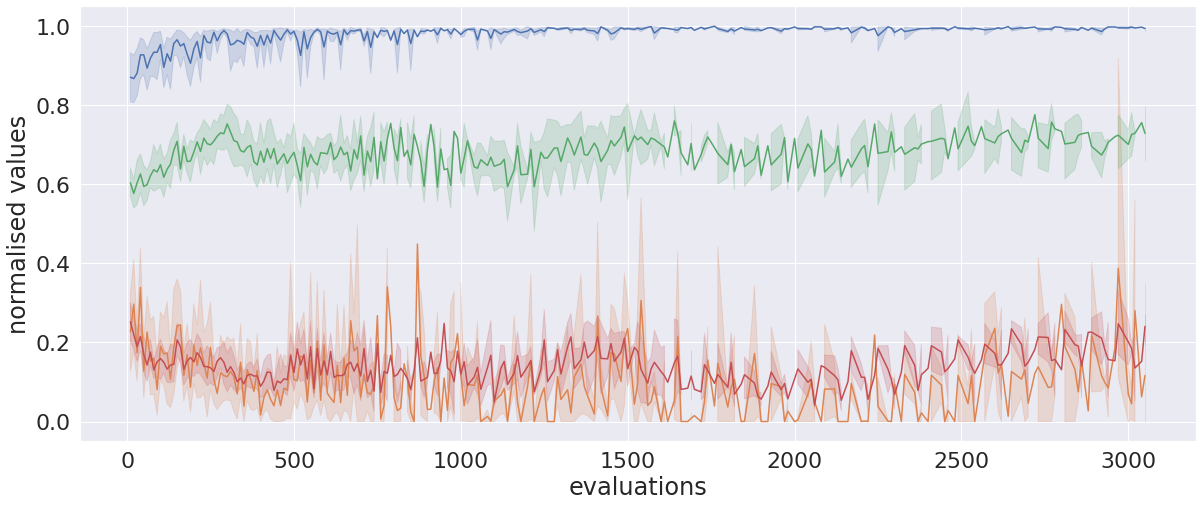

In [33]:
are_nipes_escape = "/home/leni/are-logs/are_nipes_escape_beacon_ec/"
sns.set(rc={'figure.figsize':(20,8)},font_scale=2)
x_vec = []
y_vec = []
lines = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    neval, best_fit, avg_fit,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",0)
    neval, best_nov, avg_nov,pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",1)

    neval, best_fit1, best_fit2,pop_size = load_best_fit_mo(are_nipes_escape + folder + "/fitnesses.csv")
    nbeval, eval_time = load_eval_time(are_nipes_escape + folder + "/eval_durations.csv");

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],"best fitness"])
        lines.append([neval[i],best_fit2[i],"lower energy cost"])
        lines.append([neval[i],avg_fit[i],"average fitness"])
        lines.append([neval[i],avg_nov[i],"average energy cost"])
    


d = pd.DataFrame(data=lines,columns=["evaluations","normalised values","type"]) 
sns.lineplot(x="evaluations",y="normalised values",hue="type",data=d,legend=False)


nipes_3_6_12-49-58-8504_3533189152
nipes_3_6_12-50-13-3650_673170828
nipes_3_6_12-50-13-3827_3458409153
nipes_3_6_12-50-11-1475_2220810879
nipes_3_6_12-49-59-9581_169614833
nipes_3_6_12-50-25-5749_581831253
nipes_3_6_14-12-14-4214_1824235219
nipes_3_6_12-50-16-6751_1679381984
nipes_3_6_12-50-1-1629_3569577540
nipes_3_6_12-50-7-7759_4002531379


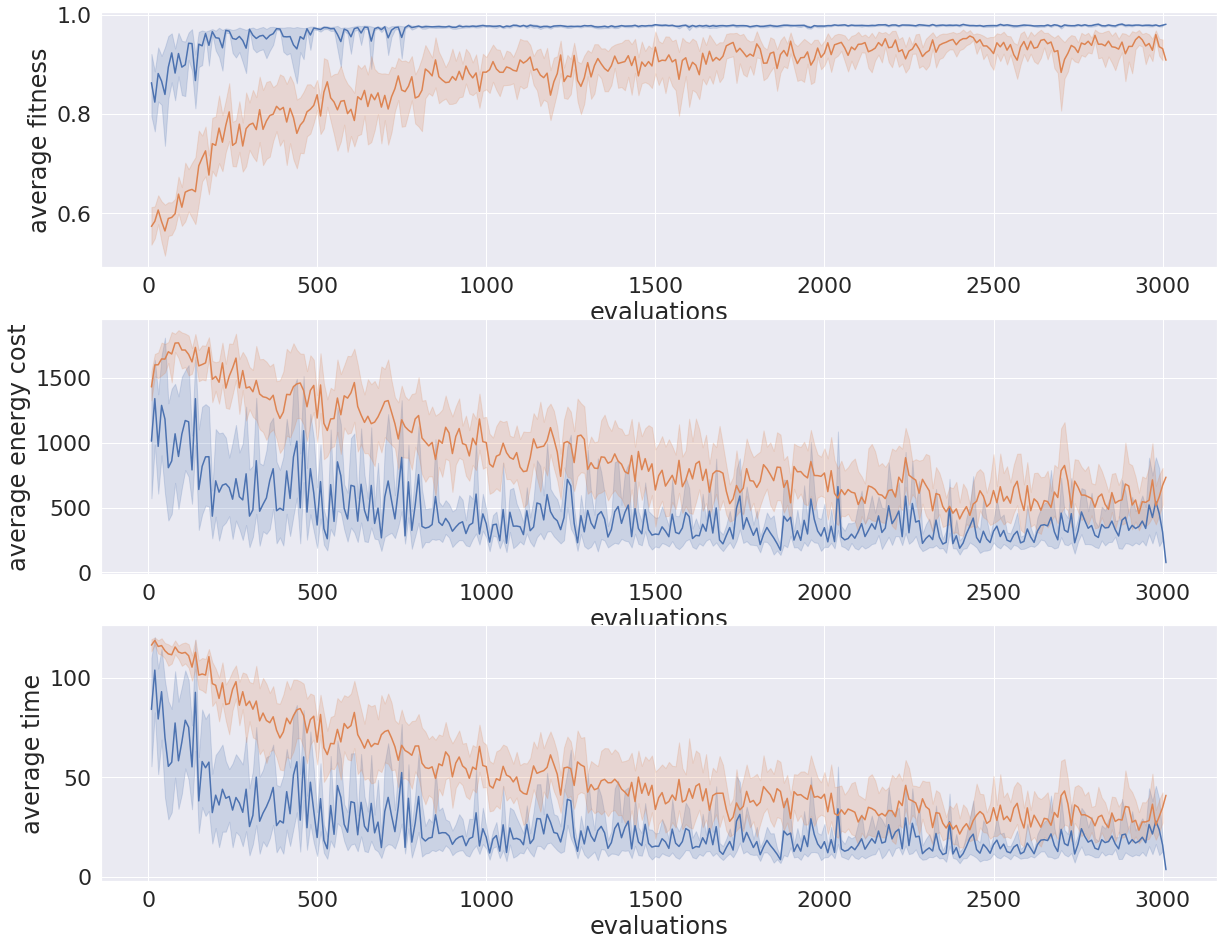

In [39]:
are_nipes_escape = "/home/leni/are-logs/are_nipes_escape_te_ee/"
sns.set(rc={'figure.figsize':(20,16)},font_scale=2)
lines = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(are_nipes_escape + folder + "/fitnesses.csv",0)
    nbeval, pop_size, ec = load_score(are_nipes_escape + folder + "/energy_cost.csv")
    nbeval, pop_size, te = load_score(are_nipes_escape + folder + "/sim_time.csv")
       
    best_fit_ec = []
    best_fit_te = []
    avg_te = []
    avg_ec = []
    glob_id = 0
    gen_count = 0
    for p in pop_size :
        ate = 0
        aec = 0
        best_fit_ec.append(ec[best_ids[gen_count] + glob_id])
        best_fit_te.append(te[best_ids[gen_count] + glob_id])
        gen_count+=1
        for i in range(p) :
            ate += te[glob_id]
            aec += ec[glob_id]
            glob_id+=1
        avg_te.append(ate/p)
        avg_ec.append(aec/p)

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],best_fit_ec[i],best_fit_te[i],avg_fit[i],avg_ec[i],avg_te[i]])
    
d = pd.DataFrame(data=lines,columns=["evaluations","best fitness","energy cost for best fitness",
                                     "time for best fitness","average fitness",
                                     "average energy cost","average time"]) 

fig, axs = plt.subplots(nrows=3)
sns.lineplot(x="evaluations",y="best fitness",data=d,ax=axs[0])
sns.lineplot(x="evaluations",y="average fitness",data=d,ax=axs[0])

sns.lineplot(x="evaluations",y="energy cost for best fitness",data=d,ax=axs[1])
sns.lineplot(x="evaluations",y="average energy cost",data=d,ax=axs[1])

sns.lineplot(x="evaluations",y="time for best fitness",data=d,ax=axs[2])
sns.lineplot(x="evaluations",y="average time",data=d,ax=axs[2])


nipes_3_6_12-49-19-9584_1197019270
nipes_3_6_12-49-16-6310_3824300798
nipes_3_6_12-49-12-2457_2236327262
nipes_3_6_12-49-34-4446_1339195603
nipes_3_6_12-49-26-6692_201161224
nipes_3_6_12-49-15-5372_1613251812
nipes_3_6_12-49-6-6486_3375995285
nipes_3_6_12-49-23-3700_3534543903
nipes_3_6_12-49-24-4203_892671932
nipes_3_6_12-49-15-5442_1215834537


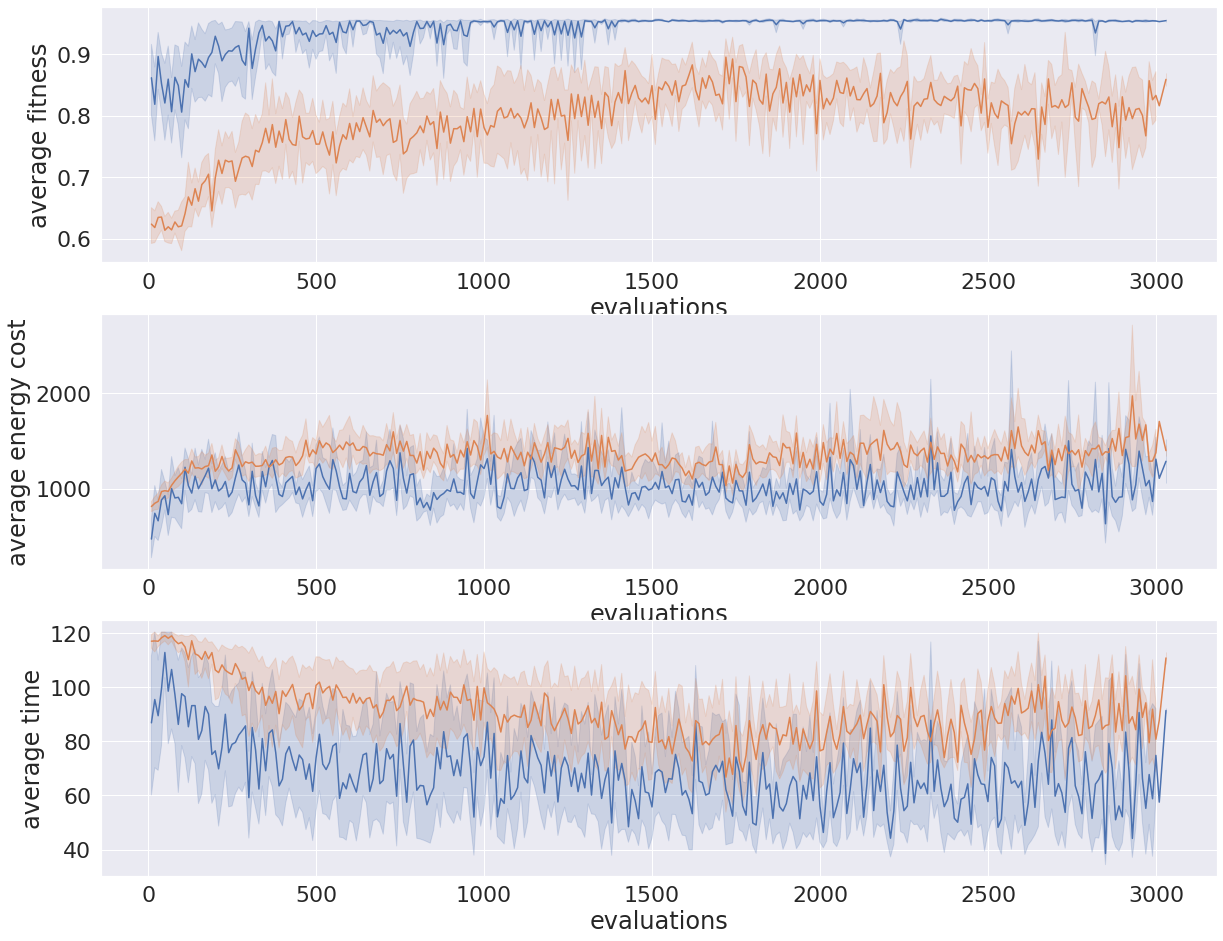

In [40]:
tri_nipes_escape = "/home/leni/are-logs/tri_nipes_escape_te_ee/"
sns.set(rc={'figure.figsize':(20,16)},font_scale=2)
lines = []
for folder in os.listdir(tri_nipes_escape) :
    if(not os.path.isdir(tri_nipes_escape + folder)) :
        continue
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(tri_nipes_escape + folder + "/fitnesses.csv",0)
    nbeval, pop_size, ec = load_score(tri_nipes_escape + folder + "/energy_cost.csv")
    nbeval, pop_size, te = load_score(tri_nipes_escape + folder + "/sim_time.csv")
       
    best_fit_ec = []
    best_fit_te = []
    avg_te = []
    avg_ec = []
    glob_id = 0
    gen_count = 0
    for p in pop_size :
        ate = 0
        aec = 0
        best_fit_ec.append(ec[best_ids[gen_count] + glob_id])
        best_fit_te.append(te[best_ids[gen_count] + glob_id])
        gen_count+=1
        for i in range(p) :
            ate += te[glob_id]
            aec += ec[glob_id]
            glob_id+=1
        avg_te.append(ate/p)
        avg_ec.append(aec/p)

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],best_fit_ec[i],best_fit_te[i],avg_fit[i],avg_ec[i],avg_te[i]])
    
d = pd.DataFrame(data=lines,columns=["evaluations","best fitness","energy cost for best fitness",
                                     "time for best fitness","average fitness",
                                     "average energy cost","average time"]) 

fig, axs = plt.subplots(nrows=3)
sns.lineplot(x="evaluations",y="best fitness",data=d,ax=axs[0])
sns.lineplot(x="evaluations",y="average fitness",data=d,ax=axs[0])

sns.lineplot(x="evaluations",y="energy cost for best fitness",data=d,ax=axs[1])
sns.lineplot(x="evaluations",y="average energy cost",data=d,ax=axs[1])

sns.lineplot(x="evaluations",y="time for best fitness",data=d,ax=axs[2])
sns.lineplot(x="evaluations",y="average time",data=d,ax=axs[2])


nipes_3_6_16-44-12-2390_2322137430
nipes_3_6_16-44-20-216_1717215060
nipes_3_6_16-44-4-4543_1765939095
nipes_3_6_16-44-33-3563_2649285990
nipes_3_6_16-44-22-2539_1757327257
nipes_3_6_16-44-6-6483_2510834435
nipes_3_6_16-44-18-8406_3027163191
nipes_3_6_16-44-28-8693_1570965804
nipes_3_6_16-44-25-5197_506460350
nipes_3_6_16-44-11-1774_65155871


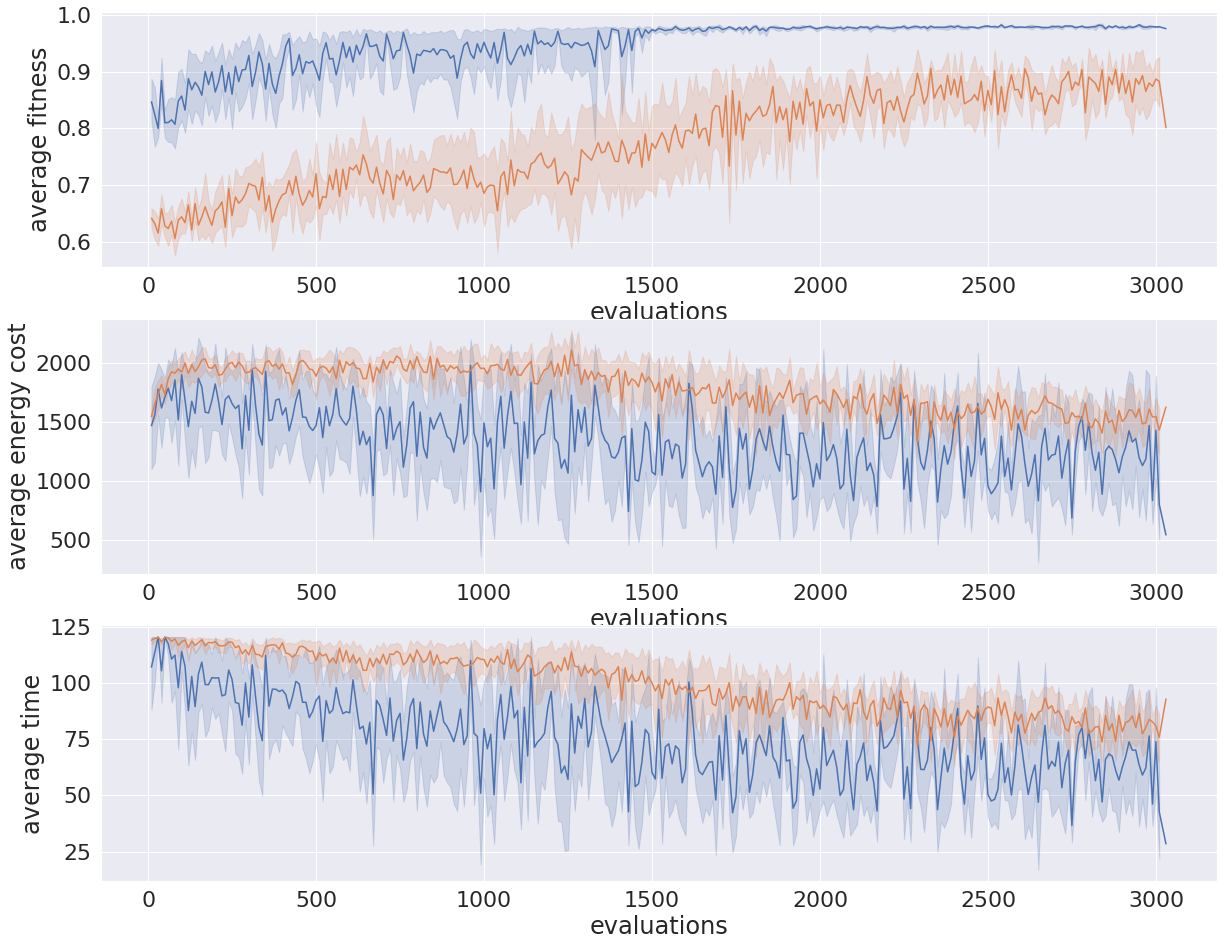

In [41]:
are_nipes_middle = "/home/leni/are-logs/are_nipes_middle_te_ee/"
sns.set(rc={'figure.figsize':(20,16)},font_scale=2)
lines = []
for folder in os.listdir(are_nipes_middle) :
    if(not os.path.isdir(are_nipes_middle + folder)) :
        continue
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(are_nipes_middle + folder + "/fitnesses.csv",0)
    nbeval, pop_size, ec = load_score(are_nipes_middle + folder + "/energy_cost.csv")
    nbeval, pop_size, te = load_score(are_nipes_middle + folder + "/sim_time.csv")
       
    best_fit_ec = []
    best_fit_te = []
    avg_te = []
    avg_ec = []
    glob_id = 0
    gen_count = 0
    for p in pop_size :
        ate = 0
        aec = 0
        best_fit_ec.append(ec[best_ids[gen_count] + glob_id])
        best_fit_te.append(te[best_ids[gen_count] + glob_id])
        gen_count+=1
        for i in range(p) :
            ate += te[glob_id]
            aec += ec[glob_id]
            glob_id+=1
        avg_te.append(ate/p)
        avg_ec.append(aec/p)

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],best_fit_ec[i],best_fit_te[i],avg_fit[i],avg_ec[i],avg_te[i]])
    
d = pd.DataFrame(data=lines,columns=["evaluations","best fitness","energy cost for best fitness",
                                     "time for best fitness","average fitness",
                                     "average energy cost","average time"]) 

fig, axs = plt.subplots(nrows=3)
sns.lineplot(x="evaluations",y="best fitness",data=d,ax=axs[0])
sns.lineplot(x="evaluations",y="average fitness",data=d,ax=axs[0])

sns.lineplot(x="evaluations",y="energy cost for best fitness",data=d,ax=axs[1])
sns.lineplot(x="evaluations",y="average energy cost",data=d,ax=axs[1])

sns.lineplot(x="evaluations",y="time for best fitness",data=d,ax=axs[2])
sns.lineplot(x="evaluations",y="average time",data=d,ax=axs[2])


nipes_4_6_13-25-24-4492_1110006504
nipes_4_6_13-25-22-2152_837666387
nipes_4_6_13-25-11-1394_2396051053
nipes_4_6_13-25-37-7115_122704879
nipes_4_6_13-25-15-5123_4205878064
nipes_4_6_13-25-32-2047_1322466432
nipes_4_6_13-25-34-4142_1504883808
nipes_4_6_13-27-28-8902_852828100
nipes_4_6_13-25-15-5617_3239430230
nipes_4_6_13-25-30-23_1318025504


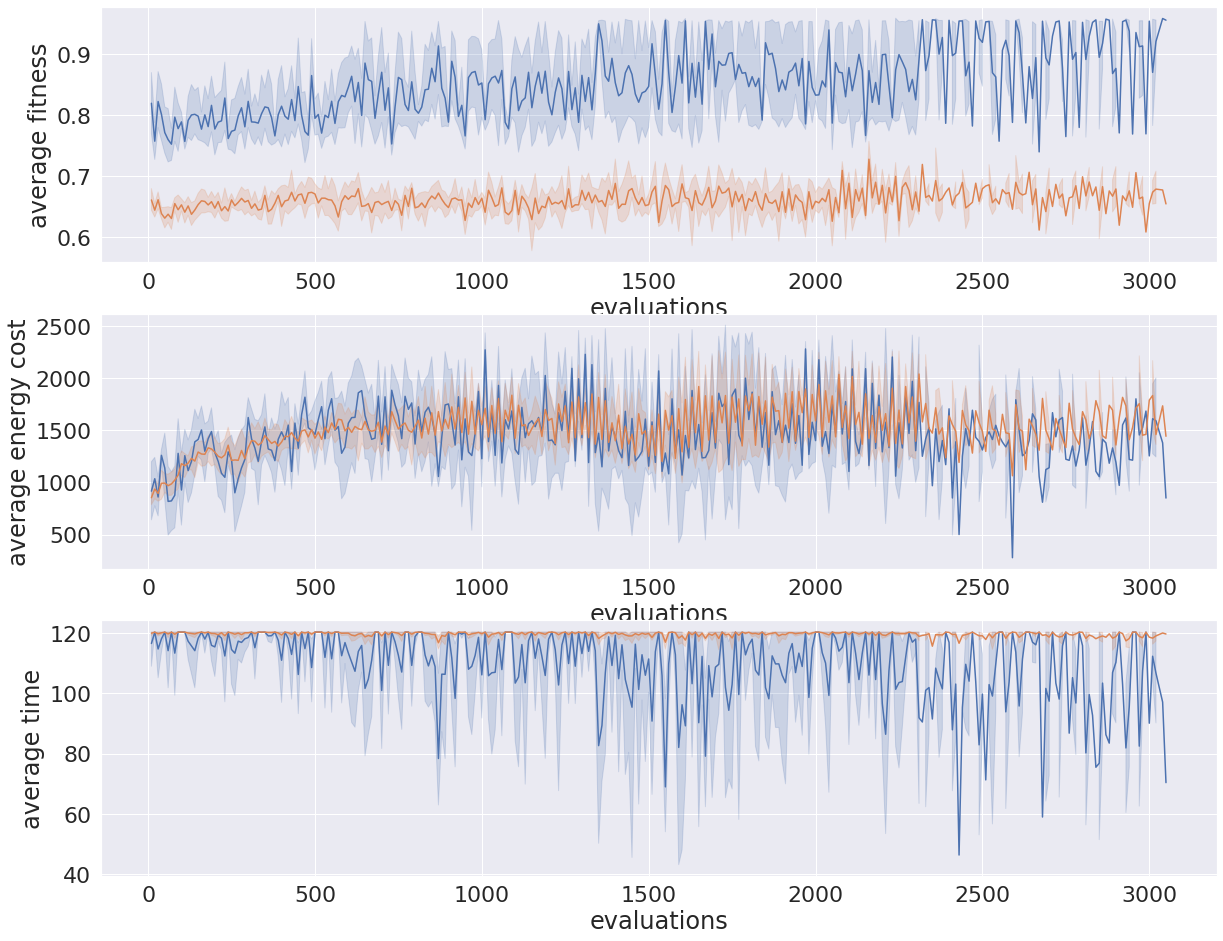

In [42]:
tri_nipes_middle = "/home/leni/are-logs/tri_nipes_middle_te_ee/"
sns.set(rc={'figure.figsize':(20,16)},font_scale=2)
lines = []
for folder in os.listdir(tri_nipes_middle) :
    if(not os.path.isdir(tri_nipes_middle + folder)) :
        continue
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(tri_nipes_middle + folder + "/fitnesses.csv",0)
    nbeval, pop_size, ec = load_score(tri_nipes_middle + folder + "/energy_cost.csv")
    nbeval, pop_size, te = load_score(tri_nipes_middle + folder + "/sim_time.csv")
       
    best_fit_ec = []
    best_fit_te = []
    avg_te = []
    avg_ec = []
    glob_id = 0
    gen_count = 0
    for p in pop_size :
        ate = 0
        aec = 0
        best_fit_ec.append(ec[best_ids[gen_count] + glob_id])
        best_fit_te.append(te[best_ids[gen_count] + glob_id])
        gen_count+=1
        for i in range(p) :
            ate += te[glob_id]
            aec += ec[glob_id]
            glob_id+=1
        avg_te.append(ate/p)
        avg_ec.append(aec/p)

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],best_fit_ec[i],best_fit_te[i],avg_fit[i],avg_ec[i],avg_te[i]])
    
d = pd.DataFrame(data=lines,columns=["evaluations","best fitness","energy cost for best fitness",
                                     "time for best fitness","average fitness",
                                     "average energy cost","average time"]) 

fig, axs = plt.subplots(nrows=3)
sns.lineplot(x="evaluations",y="best fitness",data=d,ax=axs[0])
sns.lineplot(x="evaluations",y="average fitness",data=d,ax=axs[0])

sns.lineplot(x="evaluations",y="energy cost for best fitness",data=d,ax=axs[1])
sns.lineplot(x="evaluations",y="average energy cost",data=d,ax=axs[1])

sns.lineplot(x="evaluations",y="time for best fitness",data=d,ax=axs[2])
sns.lineplot(x="evaluations",y="average time",data=d,ax=axs[2])


nipes_4_6_13-30-18-8300_2380325317
nipes_4_6_13-30-0-563_325757191
nipes_4_6_13-30-22-2462_2031229928
nipes_4_6_13-30-23-3810_3083930352
nipes_4_6_13-30-27-7451_654860945
nipes_4_6_13-30-8-8314_459259201
nipes_4_6_14-48-49-9512_1503206830
nipes_4_6_13-30-16-6540_2697562691
nipes_4_6_13-30-18-8505_4043826543
nipes_4_6_13-30-9-9554_1229225713


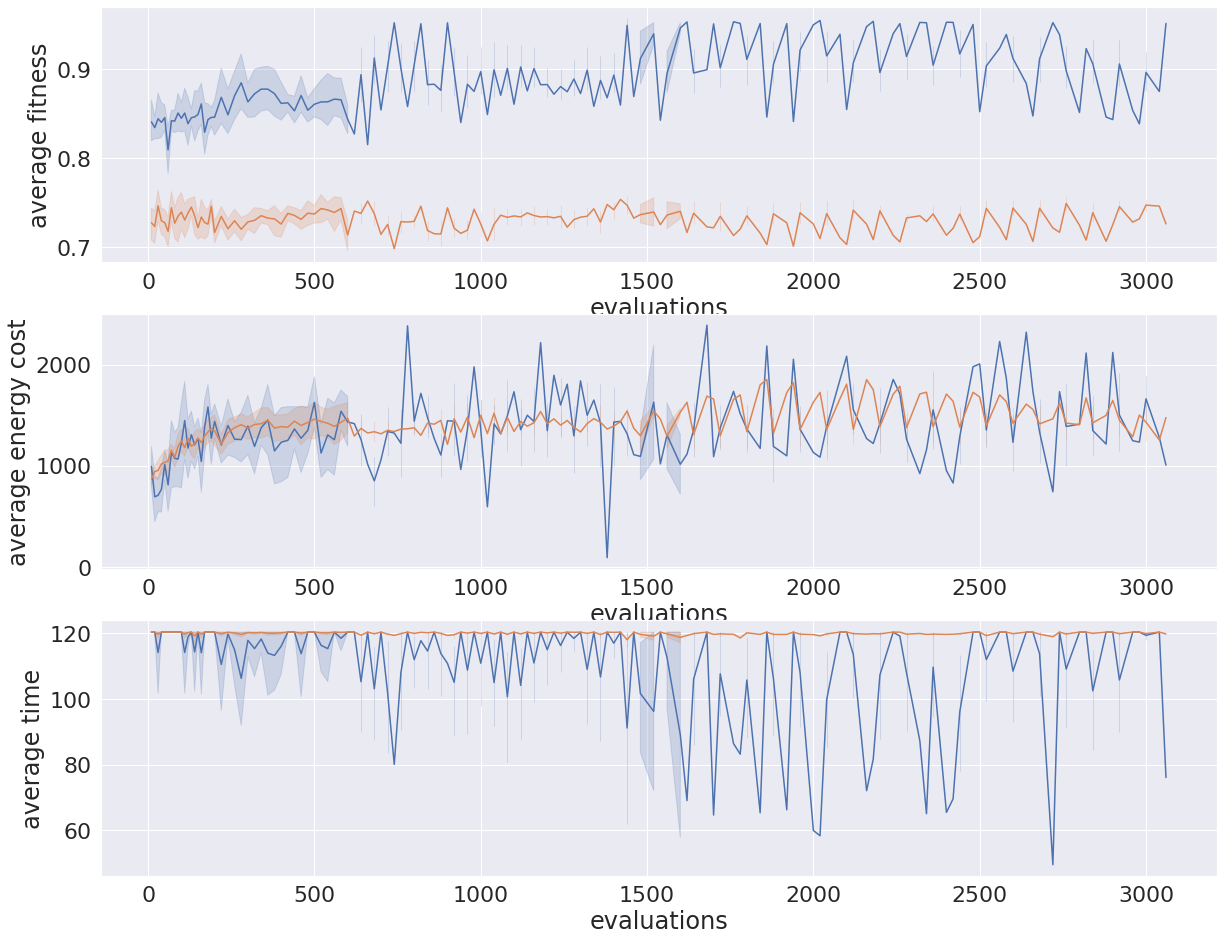

In [43]:
tri_nipes_multi = "/home/leni/are-logs/tri_nipes_multi_te_ee/"
sns.set(rc={'figure.figsize':(20,16)},font_scale=2)
lines = []
for folder in os.listdir(tri_nipes_multi) :
    if(not os.path.isdir(tri_nipes_multi + folder)) :
        continue
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(tri_nipes_multi + folder + "/fitnesses.csv",0)
    nbeval, pop_size, ec = load_score(tri_nipes_multi + folder + "/energy_cost.csv")
    nbeval, pop_size, te = load_score(tri_nipes_multi + folder + "/sim_time.csv")
       
    best_fit_ec = []
    best_fit_te = []
    avg_te = []
    avg_ec = []
    glob_id = 0
    gen_count = 0
    for p in pop_size :
        ate = 0
        aec = 0
        best_fit_ec.append(ec[best_ids[gen_count] + glob_id])
        best_fit_te.append(te[best_ids[gen_count] + glob_id])
        gen_count+=1
        for i in range(p) :
            ate += te[glob_id]
            aec += ec[glob_id]
            glob_id+=1
        avg_te.append(ate/p)
        avg_ec.append(aec/p)

    for i in range(len(neval)) :
        lines.append([neval[i],best_fit[i],best_fit_ec[i],best_fit_te[i],avg_fit[i],avg_ec[i],avg_te[i]])
    
d = pd.DataFrame(data=lines,columns=["evaluations","best fitness","energy cost for best fitness",
                                     "time for best fitness","average fitness",
                                     "average energy cost","average time"]) 

fig, axs = plt.subplots(nrows=3)
sns.lineplot(x="evaluations",y="best fitness",data=d,ax=axs[0])
sns.lineplot(x="evaluations",y="average fitness",data=d,ax=axs[0])

sns.lineplot(x="evaluations",y="energy cost for best fitness",data=d,ax=axs[1])
sns.lineplot(x="evaluations",y="average energy cost",data=d,ax=axs[1])

sns.lineplot(x="evaluations",y="time for best fitness",data=d,ax=axs[2])
sns.lineplot(x="evaluations",y="average time",data=d,ax=axs[2])


Longest path as second objective
/home/leni/are-logs/are_rs_escape_beacon/
/home/leni/are-logs/tri_rs_escape_beacon/
/home/leni/are-logs/are_nipes_escape_beacon/
/home/leni/are-logs/tri_nipes_escape_beacon/


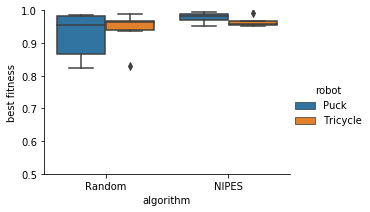

In [126]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/are_rs_escape_beacon/",
            "/home/leni/are-logs/tri_rs_escape_beacon/",
            "/home/leni/are-logs/are_nipes_escape_beacon/",
            "/home/leni/are-logs/tri_nipes_escape_beacon/"]

robot = ["Puck","Tricycle"]
maze_name =  ["escape room"]
algo = ["Random","NIPES"]
idx = [[0,0],[0,1],[1,0],[1,1]]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or (folder.split("_")[0] != "nipes" and folder.split("_")[0] != "random")) :
            continue
            
        if(folder.split("_")[0] == "nipes") :
            neval, best_fit, avg_fit,pop_size = load_all_fitnesses(dire + folder + "/fitnesses.csv",0)
            lines.append([algo[idx[i][0]],robot[idx[i][1]],best_fit[-1]])
        else : 
            fitnesses = load_fitness_of_gen(dire + folder + "/fitnesses.csv",0,0)
            if(robot[idx[i][1]] ==  "Puck") :
                nbr_samples = 20
            else :
                nbr_samples = 100
            lines.append([algo[idx[i][0]],robot[idx[i][1]],np.max(fitnesses[:nbr_samples])])
    i+=1
    
d = pd.DataFrame(data=lines,columns=["algorithm","robot","best fitness"])    
    
ax1 = sns.catplot(x="algorithm",y="best fitness",hue="robot",data=d,kind="box",aspect=1.5,height=3)
ax1.set(ylim=[0.5,1])
#ax2 = sns.catplot(x="algorithm",y="computational time",hue="robot",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

Longest path as second objective
/home/leni/are-logs/are_rs_escape_beacon/
/home/leni/are-logs/tri_rs_escape_beacon/
/home/leni/are-logs/are_rs_middle_beacon/
/home/leni/are-logs/tri_rs_middle_beacon/
/home/leni/are-logs/are_rs_multi_beacon/
/home/leni/are-logs/tri_rs_multi_beacon/
/home/leni/are-logs/are_rs_easy_beacon/
/home/leni/are-logs/tri_rs_easy_beacon/
/home/leni/are-logs/are_rs_hard_beacon/
/home/leni/are-logs/tri_rs_hard_beacon/


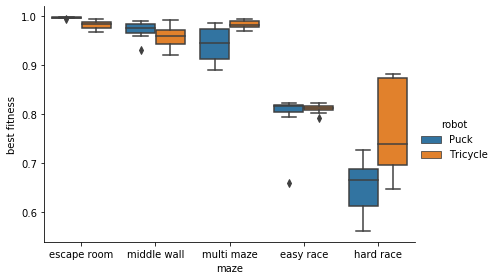

In [3]:
print("Longest path as second objective")
list_dir = ["/home/leni/are-logs/are_rs_escape_beacon/",
            "/home/leni/are-logs/tri_rs_escape_beacon/",
            "/home/leni/are-logs/are_rs_middle_beacon/",
            "/home/leni/are-logs/tri_rs_middle_beacon/",
            "/home/leni/are-logs/are_rs_multi_beacon/",
            "/home/leni/are-logs/tri_rs_multi_beacon/",
            "/home/leni/are-logs/are_rs_easy_beacon/",
            "/home/leni/are-logs/tri_rs_easy_beacon/",
            "/home/leni/are-logs/are_rs_hard_beacon/",
           "/home/leni/are-logs/tri_rs_hard_beacon/"]

robot = ["Puck","Tricycle"]
maze_name =  ["escape room","middle wall","multi maze","easy race","hard race"]
idx = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3],[0,4],[1,4]]
lines = []
i = 0
for dire in list_dir :
    neval_list = []
    neval_list_10 = []
    neval_list_15 = []
    neval_list_20 = []
    time_list = []
    print(dire)
    for folder in os.listdir(dire) :
        if(not os.path.isdir(dire + folder) or (folder.split("_")[0] != "nipes" and folder.split("_")[0] != "random")) :
            continue
        fitnesses = load_fitness_of_gen(dire + folder + "/fitnesses.csv",0,0)
        lines.append([maze_name[idx[i][1]],robot[idx[i][0]],np.max(fitnesses[:1000])])
    i+=1
    
d = pd.DataFrame(data=lines,columns=["maze","robot","best fitness"])    
    
ax1 = sns.catplot(x="maze",y="best fitness",hue="robot",data=d,kind="box",aspect=1.5,height=4)
#ax1.set(ylim=[0.5,1])
#ax2 = sns.catplot(x="algorithm",y="computational time",hue="robot",col="accuracy",data=d,kind="box",aspect=1.5,height=3,col_wrap=2)
#ax2.set(ylim=[1,10000])

In [130]:
are_nipes_escape = "/home/leni/are-logs/are_nipes_escape_robust/"
lines = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    fitnesses = load_robustness_score(are_nipes_escape + folder + "/fitnesses.csv")
    
    rob_score = []
    best_fit = []
    for f in fitnesses :
        rob_score.append(np.std(f))
        best_fit.append(np.mean(f))
    
    lines.append([np.max(best_fit),rob_score[np.argmax(best_fit)],"Puck"])

robustness_test_24_5_11-59-36-6116_822686596
robustness_test_24_5_12-39-26-6353_3682340992
robustness_test_24_5_12-15-28-8187_1563541538
robustness_test_24_5_12-31-21-1165_4132289846
robustness_test_24_5_12-23-23-3435_1793744975
robustness_test_24_5_12-55-46-6245_3031993500
robustness_test_24_5_13-3-36-6908_1487351039
robustness_test_24_5_11-51-49-9250_808730706
robustness_test_24_5_12-7-35-5322_2200720761
robustness_test_24_5_12-47-32-2332_2033791638


In [131]:
are_nipes_escape = "/home/leni/are-logs/tri_nipes_escape_robust/"
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    fitnesses = load_robustness_score(are_nipes_escape + folder + "/fitnesses.csv")
    
    rob_score = []
    best_fit = []
    for f in fitnesses :
        rob_score.append(np.std(f))
        best_fit.append(np.mean(f))
    
    lines.append([np.max(best_fit),rob_score[np.argmax(best_fit)],"Tricycle"])
    

robustness_test_24_5_23-47-4-4037_3749597034
robustness_test_25_5_0-5-42-2620_3582063390
robustness_test_25_5_0-18-12-2633_466685698
robustness_test_25_5_0-11-53-3727_1320196501
robustness_test_25_5_0-34-22-2332_3374065954
robustness_test_24_5_23-53-8-8423_2745482795
robustness_test_25_5_0-28-12-2142_4063801842
robustness_test_24_5_23-41-6-6477_3099978238
robustness_test_24_5_23-34-58-8595_2871082342
robustness_test_24_5_23-59-31-1115_43072673


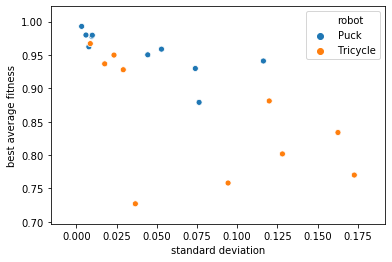

In [132]:
d = pd.DataFrame(data=lines,columns=["best average fitness","standard deviation","robot"])    
ax = sns.scatterplot(y="best average fitness",x="standard deviation",hue="robot",data=d)

robustness_test_24_5_17-16-50-163_3577586494
robustness_test_24_5_18-3-54-4530_3605306836
robustness_test_24_5_21-59-8-8036_122285261
robustness_test_24_5_14-55-36-6369_851262121
robustness_test_24_5_15-42-34-4725_3338037672
robustness_test_24_5_20-24-33-3003_3661276934
robustness_test_24_5_18-51-3-3803_2868474786
robustness_test_24_5_19-37-53-3219_1543679415
robustness_test_24_5_16-29-32-2903_1019299820
robustness_test_24_5_21-12-4-4120_697319730


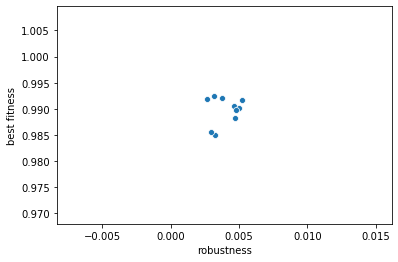

In [103]:
are_nipes_escape = "/home/leni/are-logs/are_nipes_escape_ec_robust/"
lines = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    fitnesses = load_robustness_score(are_nipes_escape + folder + "/fitnesses.csv")
    
    rob_score = []
    best_fit = []
    for f in fitnesses :
        rob_score.append(np.std(f))
        best_fit.append(np.mean(f))
    
    lines.append([np.max(best_fit),rob_score[np.argmax(best_fit)]])
    
d = pd.DataFrame(data=lines,columns=["best fitness","robustness"])    
sns.scatterplot(x="robustness",y="best fitness",data=d)


robustness_test_25_5_13-5-38-8348_1153958100
robustness_test_25_5_11-20-31-1548_1991918136
robustness_test_25_5_14-15-25-5637_2550923942
robustness_test_25_5_9-0-44-4998_4236297082
robustness_test_25_5_13-40-18-8663_2975612326
robustness_test_25_5_10-45-36-6830_130246137
robustness_test_25_5_12-30-32-2097_1822555602
robustness_test_25_5_10-10-42-2649_106687287
robustness_test_25_5_11-55-50-584_1414997921
robustness_test_25_5_9-35-44-4788_1673536903


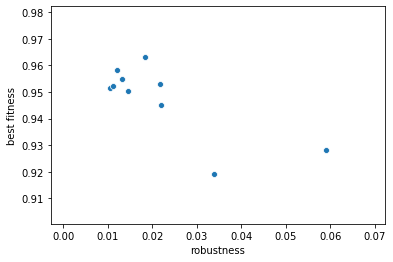

In [104]:
are_nipes_escape = "/home/leni/are-logs/tri_nipes_escape_ec_robust/"
lines = []
for folder in os.listdir(are_nipes_escape) :
    if(not os.path.isdir(are_nipes_escape + folder)) :
        continue
    print(folder)
    fitnesses = load_robustness_score(are_nipes_escape + folder + "/fitnesses.csv")
    
    rob_score = []
    best_fit = []
    for f in fitnesses :
        rob_score.append(np.std(f))
        best_fit.append(np.mean(f))
    
    lines.append([np.max(best_fit),rob_score[np.argmax(best_fit)]])
    
d = pd.DataFrame(data=lines,columns=["best fitness","robustness"])    
sns.scatterplot(x="robustness",y="best fitness",data=d)
